<a href="https://colab.research.google.com/github/hikaru122700/kaggle-private/blob/SMBC/095.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [388]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [389]:
!pip install pygeohash
!pip install catboost
!pip install lightgbm
!pip install xgboost
!pip install optuna

In [390]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import math

# import pygeohash as pgh

from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

import gc
gc.collect()
import optuna
import matplotlib.pyplot as plt


import os
from catboost import CatBoostClassifier


In [391]:
path  = "/content/drive/My Drive/signate/SMBC Group GREEN×DATA Challenge 2024/"
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv(path+'train.csv', index_col=0)

# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv(path+'test.csv', index_col=0)

In [392]:
train_df

,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
0,VISCOFAN USA INC,40,-88,915 N MICHIGAN AVE,DANVILLE,IL,61832,VERMILION,"17,183",326121,NaN,Other,"31,567","26,645","23,410","31,810","64,817","36,589","37,908","45,598","52,973"
1,"CORNWELL STATION - DOMINION TRANSMISSION, INC",38,-81,200 RIVER HAVEN ROAD,CLENDENIN,WV,25045-9304,KANAWHA,"54,039",486210,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,"55,508","72,387","58,225","76,377","55,910"
2,WEST UNION COMPRESSOR STATION,39,-81,3041 LONG RUN RD.,GREENWOOD,WV,26415,RITCHIE,"54,085",211112,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"55,680"
3,"DOUBLE ""C"" LIMITED",35,-119,10245 OILFIELD ROAD,BAKERSFIELD,CA,93308,KERN,"6,029",221112,NaN,Power Plants,NaN,NaN,NaN,NaN,"54,811","69,340","63,647","53,799","61,412"
4,LAKESHORE PLANT,42,-82,6800 S MARGINAL RD,CLEVELAND,OH,441031047,CUYAHOGA,"39,035",221112,NaN,Power Plants,"29,554","28,338","30,841","25,154","81,812","53,824","77,391","17,663","43,100"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,MIDLOTHIAN COMPRESSOR STATION,33,-97,2624 CHAMBERS ST.,VENUS,TX,76084,JOHNSON,"48,251",211111,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,"54,979","56,464","3,522,786","76,643","2,451,197"
4651,PARADISE COMPRESSOR STATION,43,-110,"SECTION 2, T31N, R109W",PINEDALE,WY,82941,SUBLETTE,"56,035",211111,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,"208,375","57,067","48,580","26,892","35,740"
4652,UNIV OF OK HEALTH S/OKC CAMPUS SVCS,35,-97,800 NE 15TH ST,OKLAHOMA CITY,OK,73104,OKLAHOMA,"40,109",611310,NaN,Other,NaN,NaN,NaN,NaN,"563,756","598,881","1,665,103","543,206","978,359"
4653,HARFORD CO. RESOURCE RECOVERY FACILITY,39,-76,1 MAGNOLIA ROAD,JOPPA,MD,21085-4800,HARFORD,"24,025",562213,NaN,Waste,NaN,NaN,NaN,NaN,"67,451","27,398","39,228","46,635","27,234"


In [393]:
# すべての列を表示するように設定
pd.set_option('display.max_columns', None)
train_df.columns

Index(['FacilityName', 'Latitude', 'Longitude', 'LocationAddress', 'City',
       'State', 'ZIP', 'County', 'FIPScode', 'PrimaryNAICS',
       'SecondPrimaryNAICS', 'IndustryType', 'TRI_Air_Emissions_10_in_lbs',
       'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs',
       'TRI_Air_Emissions_13_in_lbs', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons',
       'GHG_Direct_Emissions_14_in_metric_tons'],
      dtype='object')

In [394]:
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

In [395]:
# del train_df['Unnamed: 0'], test_df['Unnamed: 0']
del train_df['FacilityName'], test_df['FacilityName']
del train_df['LocationAddress'], test_df['LocationAddress']
del train_df['ZIP'], test_df['ZIP']
del train_df['IndustryType'], test_df['IndustryType']
del train_df['SecondPrimaryNAICS'], test_df['SecondPrimaryNAICS']

In [396]:

two_digit_map     = {11: 'Agriculture, Forestry, Fishing and Hunting',
                    21: 'Mining, Quarrying, and Oil and Gas Extraction',
                    22: 'Utilities',
                    23: 'Construction',
                    31: 'Manufacturing',
                    32: 'Manufacturing',
                    33: 'Manufacturing',
                    42: 'Wholesale Trade',
                    44: 'Retail Trade',
                    45: 'Retail Trade',
                    48: 'Transportation and Warehousing',
                    49: 'Transportation and Warehousing',
                    51: 'Information',
                    52: 'Finance and Insurance',
                    53: 'Real Estate and Rental and Leasing',
                    54: 'Professional, Scientific, and Technical Services',
                    55: 'Management of Companies and Enterprises',
                    56: 'Administrative and Support and Waste Management and Remediation Services',
                    61: 'Educational Services',
                    62: 'Health Care and Social Assistance',
                    71: 'Arts, Entertainment, and Recreation',
                    72: 'Accommodation and Food Services',
                    81: 'Other Services (except Public Administration)',
                    92: 'Public Administration'}

In [397]:
train_df['first_two_digit_primary_naics'] = train_df['PrimaryNAICS'].apply(lambda z: str(z)[:2]).astype(int)
test_df['first_two_digit_primary_naics']  = test_df['PrimaryNAICS'].apply(lambda z: str(z)[:2]).astype(int)

train_df['Economic_Sector']               = train_df['first_two_digit_primary_naics'].map(two_digit_map)
test_df['Economic_Sector']                = test_df['first_two_digit_primary_naics'].map(two_digit_map)

del train_df['first_two_digit_primary_naics'], test_df['first_two_digit_primary_naics']

econ_sector_train                         = train_df['Economic_Sector'].values
econ_sector_test                          = test_df['Economic_Sector'].values

In [398]:
test_df.shape

(2508, 16)

In [399]:



def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Radius of Earth in kilometers (mean radius)
    R = 6371.0

    # Calculate the distance
    distance = R * c
    return distance

In [400]:
def calculate_distance(lat1, lon1, lat2, lon2):
    return haversine(lat1, lon1, lat2, lon2)

def get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=5, train_point=False):
    # Extract the required columns once to NumPy arrays
    latitudes = train_df['Latitude'].values
    longitudes = train_df['Longitude'].values
    ghg_emissions = train_df['GHG_Direct_Emissions_14_in_metric_tons'].values
    econ_sectors = train_df['Economic_Sector'].values

    # Filter NaN emissions directly
    valid_indices = ~np.isnan(ghg_emissions)

    latitudes = latitudes[valid_indices]
    longitudes = longitudes[valid_indices]
    ghg_emissions = ghg_emissions[valid_indices]
    econ_sectors = econ_sectors[valid_indices]

    # Parallelize distance calculation using ThreadPoolExecutor
    with ThreadPoolExecutor() as executor:
        distances = list(executor.map(calculate_distance,
                                     [lat1]*len(latitudes),
                                     [lon1]*len(longitudes),
                                     latitudes,
                                     longitudes))

    # Combine the results into a DataFrame
    near_df = pd.DataFrame({
        'Distance': distances,
        'GHG_emission_14': ghg_emissions,
        'Economic_Sector': econ_sectors
    })


    if train_point:
        near_df.sort_values(by='Distance', inplace=True)
        near_df = near_df.dropna()
        near_df = near_df.iloc[1:].reset_index(drop=True)
    else:
        # Sort distances by 'Distance'
        near_df.sort_values(by='Distance', inplace=True)
        near_df = near_df.dropna()

    # Filter by economic sector
    nearest_locations_econ_sector = near_df[near_df['Economic_Sector'] == econ_sector_ref]

    # Get the top N nearest for both economic sector and overall
    sub_near_econ = nearest_locations_econ_sector.head(neighbours)
    sub_nearest_locations = near_df.head(neighbours)

    # Compute weighted averages
    econ_weighted_average = (sub_near_econ['GHG_emission_14'] / np.where(sub_near_econ['Distance'] == 0, 1, sub_near_econ['Distance']) ).sum()
    near_weighted_average = (sub_nearest_locations['GHG_emission_14'] / np.where(sub_nearest_locations['Distance']==0,1,sub_nearest_locations['Distance'])).sum()

    # Compute regular averages
    econ_average = sub_near_econ['GHG_emission_14'].mean()
    near_average = sub_nearest_locations['GHG_emission_14'].mean()

    return [econ_weighted_average, econ_average, near_weighted_average, near_average]

In [401]:
# neighbours = 5

# # テストデータの距離計算または読み込み
# file_path = f"test_distance_{neighbours}nbrs.csv"
# if os.path.exists(file_path):
#     print(f"{file_path} exists.")
#     test_distance = pd.read_csv(file_path)
# else:
#     output = []
#     for index in tqdm(range(test_df.shape[0])):
#         lat1 = test_df.iloc[index]['Latitude']
#         lon1 = test_df.iloc[index]['Longitude']
#         econ_sector_ref = test_df.iloc[index]['Economic_Sector']
#         x = get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=neighbours, train_point=False)
#         output.append(x)

#     test_distance = pd.DataFrame(output, columns=['Economy_Sector_Weighted_Avg', 'Economic_Sector_Average', 'Nearest_Weighted_Average', 'Nearest_Average'])
#     test_distance.to_csv(file_path, index=False)

# # トレーニングデータの距離計算または読み込み
# file_path = f"train_distance_{neighbours}nbrs.csv"  # f-string を正しく使用
# if os.path.exists(file_path):
#     print(f"{file_path} exists.")
#     train_distance = pd.read_csv(file_path)
# else:
#     output = []
#     for index in tqdm(range(train_df.shape[0])):
#         lat1 = train_df.iloc[index]['Latitude']
#         lon1 = train_df.iloc[index]['Longitude']
#         econ_sector_ref = train_df.iloc[index]['Economic_Sector']
#         x = get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=neighbours, train_point=True)
#         output.append(x)

#     train_distance = pd.DataFrame(output, columns=['Economy_Sector_Weighted_Avg', 'Economic_Sector_Average', 'Nearest_Weighted_Average', 'Nearest_Average'])
#     train_distance.to_csv(file_path, index=False)

train_distance = pd.read_csv(path+"train_distance_5nbrs.csv")
test_distance  = pd.read_csv(path+"test_distance_5nbrs.csv")

In [402]:
test_df

,Latitude,Longitude,City,State,County,FIPScode,PrimaryNAICS,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Economic_Sector
0,38,-98,HUTCHINSON,KS,RENO,"20,155",211112,NaN,NaN,NaN,NaN,"88,951","65,803","28,993","32,965","Mining, Quarrying, and Oil and Gas Extraction"
1,32,-109,LORDSBURG,NM,HIDALGO,"35,023",486210,NaN,NaN,NaN,NaN,NaN,NaN,"311,926","268,668",Transportation and Warehousing
2,41,-79,BROCKPORT,PA,JEFFERSON,"42,065",327213,"28,275","32,075","26,446","23,385","84,908","6,213","34,733","39,045",Manufacturing
3,45,-93,SAINT PAUL,MN,RAMSEY,"27,123",322130,"37,330","42,504","43,906","42,958","49,005",52,"14,262","20,205",Manufacturing
4,33,-117,SAN DIEGO,CA,SAN DIEGO,"6,073",333611,"45,311","39,898","40,203","39,437","84,960","15,351","40,007","63,935",Manufacturing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,39,-76,HURLOCK,MD,DORCHESTER,"24,019",562212,NaN,NaN,NaN,NaN,"110,523","98,955","3,467,008","147,802",Administrative and Support and Waste Managemen...
2504,31,-102,RANKIN,TX,UPTON,"48,461",211112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Mining, Quarrying, and Oil and Gas Extraction"
2505,41,-96,LOUISVILLE,NE,CASS,"31,025",327310,"22,956","23,592","25,069","24,560","166,520","469,733","82,559","85,775",Manufacturing
2506,39,-93,CARROLLTON,MO,CARROLL,"29,033",325193,"124,461","140,816","93,119","130,327","71,774","936,032","336,961","156,640",Manufacturing


In [403]:
test_distance

,Economy_Sector_Weighted_Avg,Economic_Sector_Average,Nearest_Weighted_Average,Nearest_Average
0,"28,020","369,615","454,848","606,222"
1,"1,297","75,373","26,393","299,096"
2,"59,857","44,341","81,534","203,832"
3,"45,266","127,292","297,072","405,635"
4,"8,839","70,847","617,665","290,001"
...,...,...,...,...
2503,"46,677","344,617","45,283","309,317"
2504,"290,187","544,751","290,187","544,751"
2505,"102,526","658,668","100,759","598,531"
2506,"3,259","58,048","8,262","91,773"


In [404]:
train_df.shape

(4655, 17)

In [405]:
train_df = pd.concat([train_df, train_distance], axis=1)
test_df = pd.concat([test_df, test_distance], axis=1)


In [406]:
def create_features1(df):


    # Year-over-year difference
    df['TRI_Air_Emissions_YoY_Change_11'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_12'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_13'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

   # Year-over-year growth rate with NaN protection
    df['TRI_Air_Emissions_Growth_Rate_11'] = np.where(
        df['TRI_Air_Emissions_10_in_lbs'].notna() & (df['TRI_Air_Emissions_10_in_lbs'] != 0),
        (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs'],
        np.nan
    )

    df['TRI_Air_Emissions_Growth_Rate_12'] = np.where(
        df['TRI_Air_Emissions_11_in_lbs'].notna() & (df['TRI_Air_Emissions_11_in_lbs'] != 0),
        (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs'],
        np.nan
    )

    df['TRI_Air_Emissions_Growth_Rate_13'] = np.where(
        df['TRI_Air_Emissions_12_in_lbs'].notna() & (df['TRI_Air_Emissions_12_in_lbs'] != 0),
        (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs'],
        np.nan
    )

    return df

train_df      = create_features1(train_df)
test_df       = create_features1(test_df)
new_features1 = ['TRI_Air_Emissions_YoY_Change_11','TRI_Air_Emissions_YoY_Change_12','TRI_Air_Emissions_YoY_Change_13',
                 'TRI_Air_Emissions_Growth_Rate_11','TRI_Air_Emissions_Growth_Rate_12','TRI_Air_Emissions_Growth_Rate_13']

In [407]:
def create_features2(df):


    # Year-over-year difference
    df['GHG_Direct_Emissions_YoY_Change_11'] = df['GHG_Direct_Emissions_11_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']
    df['GHG_Direct_Emissions_YoY_Change_12'] = df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']
    df['GHG_Direct_Emissions_YoY_Change_13'] = df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_12_in_metric_tons']

    # Year-over-year growth rate for GHG Direct Emissions with NaN protection
    df['GHG_Direct_Emissions_Growth_Rate_11'] = np.where(
        df['GHG_Direct_Emissions_10_in_metric_tons'].notna() & (df['GHG_Direct_Emissions_10_in_metric_tons'] != 0),
        (df['GHG_Direct_Emissions_11_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']) / df['GHG_Direct_Emissions_10_in_metric_tons'],
        np.nan
    )

    df['GHG_Direct_Emissions_Growth_Rate_12'] = np.where(
        df['GHG_Direct_Emissions_11_in_metric_tons'].notna() & (df['GHG_Direct_Emissions_11_in_metric_tons'] != 0),
        (df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']) / df['GHG_Direct_Emissions_11_in_metric_tons'],
        np.nan
    )

    df['GHG_Direct_Emissions_Growth_Rate_13'] = np.where(
        df['GHG_Direct_Emissions_12_in_metric_tons'].notna() & (df['GHG_Direct_Emissions_12_in_metric_tons'] != 0),
        (df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_12_in_metric_tons']) / df['GHG_Direct_Emissions_12_in_metric_tons'],
        np.nan
    )

    return df


new_features2 = ['GHG_Direct_Emissions_YoY_Change_11','GHG_Direct_Emissions_YoY_Change_12','GHG_Direct_Emissions_YoY_Change_13',
                 'GHG_Direct_Emissions_Growth_Rate_11','GHG_Direct_Emissions_Growth_Rate_12','GHG_Direct_Emissions_Growth_Rate_13'
                 ]
train_df      = create_features2(train_df)
test_df       = create_features2(test_df)

In [408]:
def create_features3(df):
    df['TRI_to_GHG_Ratio_10'] = np.where(df['GHG_Direct_Emissions_10_in_metric_tons'].notna(),
                                     df['TRI_Air_Emissions_10_in_lbs'] / df['GHG_Direct_Emissions_10_in_metric_tons'],
                                     np.nan)

    df['TRI_to_GHG_Ratio_11'] = np.where(df['GHG_Direct_Emissions_11_in_metric_tons'].notna(),
                                        df['TRI_Air_Emissions_11_in_lbs'] / df['GHG_Direct_Emissions_11_in_metric_tons'],
                                        np.nan)

    df['TRI_to_GHG_Ratio_12'] = np.where(df['GHG_Direct_Emissions_12_in_metric_tons'].notna(),
                                        df['TRI_Air_Emissions_12_in_lbs'] / df['GHG_Direct_Emissions_12_in_metric_tons'],
                                        np.nan)

    df['TRI_to_GHG_Ratio_13'] = np.where(df['GHG_Direct_Emissions_13_in_metric_tons'].notna(),
                                        df['TRI_Air_Emissions_13_in_lbs'] / df['GHG_Direct_Emissions_13_in_metric_tons'],
                                        np.nan)
    return df



train_df      = create_features3(train_df)
test_df       = create_features3(test_df)
new_features3 = ['TRI_to_GHG_Ratio_10','TRI_to_GHG_Ratio_11','TRI_to_GHG_Ratio_12','TRI_to_GHG_Ratio_13']

In [409]:
summary_df = train_df.groupby(['Economic_Sector', 'State']).agg({'GHG_Direct_Emissions_14_in_metric_tons': ['mean', 'median', 'max', 'min','count']})

summary_df.columns = [
                        'GHG_Direct_Emissions_14_in_metric_tons_mean',
                        'GHG_Direct_Emissions_14_in_metric_tons_median',
                        'GHG_Direct_Emissions_14_in_metric_tons_max',
                        'GHG_Direct_Emissions_14_in_metric_tons_min',
                        'GHG_Direct_Emissions_14_in_metric_tons_count'
                     ]

summary_df = summary_df.reset_index()

train_df = train_df.merge(summary_df, on=['Economic_Sector', 'State'], how='left')
test_df  = test_df.merge(summary_df,  on=['Economic_Sector', 'State'], how='left')

In [410]:
test_df.shape

(2508, 41)

In [411]:
train_df.shape

(4655, 42)

In [412]:
merged_df = pd.concat((train_df,test_df),axis=0)
for cols in ['City','State','County','FIPScode','PrimaryNAICS','Economic_Sector']:
    le              = LabelEncoder()
    merged_df[cols] = le.fit_transform(merged_df[cols].values.reshape(-1,1))

train_df = merged_df.iloc[:train_df.shape[0],:]
test_df  = merged_df.iloc[train_df.shape[0]:,:]
train_df.shape,test_df.shape

((4655, 42), (2508, 42))

In [413]:
train_df["num_missing"] = train_df.iloc[:, 5:9].isna().any(axis=1).astype(int)
test_df["num_missing"] = test_df.iloc[:, 5:9].isna().any(axis=1).astype(int)
train_df["num_missing"]

,num_missing
0,0
1,1
2,1
3,1
4,0
...,...
4650,1
4651,1
4652,1
4653,1


In [414]:
train_df

,Latitude,Longitude,City,State,County,FIPScode,PrimaryNAICS,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons,Economic_Sector,Economy_Sector_Weighted_Avg,Economic_Sector_Average,Nearest_Weighted_Average,Nearest_Average,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,GHG_Direct_Emissions_YoY_Change_11,GHG_Direct_Emissions_YoY_Change_12,GHG_Direct_Emissions_YoY_Change_13,GHG_Direct_Emissions_Growth_Rate_11,GHG_Direct_Emissions_Growth_Rate_12,GHG_Direct_Emissions_Growth_Rate_13,TRI_to_GHG_Ratio_10,TRI_to_GHG_Ratio_11,TRI_to_GHG_Ratio_12,TRI_to_GHG_Ratio_13,GHG_Direct_Emissions_14_in_metric_tons_mean,GHG_Direct_Emissions_14_in_metric_tons_median,GHG_Direct_Emissions_14_in_metric_tons_max,GHG_Direct_Emissions_14_in_metric_tons_min,GHG_Direct_Emissions_14_in_metric_tons_count,num_missing
0,40,-88,760,15,1210,404,118,"31,567","26,645","23,410","31,810","64,817","36,589","37,908","45,598","52,973",8,"5,398","47,190","9,792","33,589","-4,922","-3,235","8,399",-0,-0,0,"-28,228","1,319","7,690",-0,0,0,0,1,1,1,"224,420","58,246","3,115,016","4,809",65,0
1,38,-81,596,52,580,1812,221,NaN,NaN,NaN,NaN,"55,508","72,387","58,225","76,377","55,910",14,"162,818","400,093","148,763","132,465",NaN,NaN,NaN,NaN,NaN,NaN,"16,880","-14,162","18,151",0,-0,0,NaN,NaN,NaN,NaN,"237,021","170,271","662,510","38,397",10,1
2,39,-81,1267,52,971,1831,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"55,680",9,"103,978","417,285","218,812","483,238",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"142,552","63,549","1,509,645","10,597",44,1
3,35,-119,158,4,597,118,21,NaN,NaN,NaN,NaN,"54,811","69,340","63,647","53,799","61,412",15,"131,971","103,867","131,971","103,867",NaN,NaN,NaN,NaN,NaN,NaN,"14,529","-5,693","-9,848",0,-0,-0,NaN,NaN,NaN,NaN,"247,799","67,578","2,486,906","4,179",98,1
4,42,-82,598,36,289,1206,21,"29,554","28,338","30,841","25,154","81,812","53,824","77,391","17,663","43,100",15,"13,381","32,692","59,477","94,821","-1,216","2,503","-5,687",-0,0,-0,"-27,989","23,568","-59,728",-0,0,-1,0,1,0,1,"180,513","45,651","2,126,404","12,939",26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,33,-97,3123,45,570,1588,3,NaN,NaN,NaN,NaN,"54,979","56,464","3,522,786","76,643","2,451,197",9,"180,502","330,575","116,105","145,932",NaN,NaN,NaN,NaN,NaN,NaN,"1,485","3,466,322","-3,446,143",0,61,-1,NaN,NaN,NaN,NaN,"292,116","66,395","3,422,654","3,292",184,1
4651,43,-110,2382,53,1135,1898,3,NaN,NaN,NaN,NaN,"208,375","57,067","48,580","26,892","35,740",9,"54,998","348,658","54,998","348,658",NaN,NaN,NaN,NaN,NaN,NaN,"-151,309","-8,486","-21,688",-1,-0,-0,NaN,NaN,NaN,NaN,"297,602","67,780","2,990,948","14,635",44,1
4652,35,-97,2231,37,842,1301,244,NaN,NaN,NaN,NaN,"563,756","598,881","1,665,103","543,206","978,359",5,672,"62,160","36,607","103,844",NaN,NaN,NaN,NaN,NaN,NaN,"35,125","1,066,222","-1,121,897",0,2,-1,NaN,NaN,NaN,NaN,"978,359","978,359","978,359","978,359",1,1
4653,39,-76,1533,21,486,718,241,NaN,NaN,NaN,NaN,"67,451","27,398","39,228","46,635","27,234",1,"28,225","107,929","22,104","56,751",NaN,NaN,NaN,NaN,NaN,NaN,"-40,053","11,830","7,407",-1,0,0,NaN,NaN,NaN,NaN,"281,591","98,075","1,295,239","10,230",22,1


In [415]:
numerical_columns = [
                    'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
                    'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs','PrimaryNAICS',
                    'GHG_Direct_Emissions_10_in_metric_tons', 'GHG_Direct_Emissions_11_in_metric_tons',
                    'GHG_Direct_Emissions_12_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons',
                    ]
lat_lon_columns   = ['Latitude','Longitude']
target_columns    = ['GHG_Direct_Emissions_14_in_metric_tons']
categorical_columns = ['City','State','County','FIPScode','PrimaryNAICS','Economic_Sector']
train_aggregations  =  [
                        'GHG_Direct_Emissions_14_in_metric_tons_mean',
                        'GHG_Direct_Emissions_14_in_metric_tons_median',
                        'GHG_Direct_Emissions_14_in_metric_tons_max',
                        'GHG_Direct_Emissions_14_in_metric_tons_min',
                        'GHG_Direct_Emissions_14_in_metric_tons_count'
                     ]
new_features1  = ['TRI_Air_Emissions_YoY_Change_11','TRI_Air_Emissions_YoY_Change_12','TRI_Air_Emissions_YoY_Change_13',
                    'TRI_Air_Emissions_Growth_Rate_11','TRI_Air_Emissions_Growth_Rate_12','TRI_Air_Emissions_Growth_Rate_13']

new_features2   = ['GHG_Direct_Emissions_YoY_Change_11','GHG_Direct_Emissions_YoY_Change_12','GHG_Direct_Emissions_YoY_Change_13',
                  'GHG_Direct_Emissions_Growth_Rate_11','GHG_Direct_Emissions_Growth_Rate_12','GHG_Direct_Emissions_Growth_Rate_13'
                  ]
new_features3   = ['TRI_to_GHG_Ratio_10','TRI_to_GHG_Ratio_11','TRI_to_GHG_Ratio_12','TRI_to_GHG_Ratio_13']
neighbour_feats = ['Economy_Sector_Weighted_Avg','Economic_Sector_Average','Nearest_Weighted_Average','Nearest_Average']


train = train_df[numerical_columns+
                 lat_lon_columns+
                #  categorical_columns+
                 new_features1+['Economic_Sector']
                #  new_features2
               #   new_features3+
                #  train_aggregations+
               #   neighbour_feats
                 +["num_missing"]
                 ].values
test  = test_df[numerical_columns+
                 lat_lon_columns+
                #  categorical_columns+
                 new_features1+['Economic_Sector']
                #  new_features2
               #   new_features3+
                #  train_aggregations+
               #   neighbour_feats
                +["num_missing"]
                 ].values
target = train_df[target_columns].values


In [416]:
test_df[numerical_columns+
                 lat_lon_columns+
                #  categorical_columns+
                 new_features1+['Economic_Sector']
                #  new_features2
               #   new_features3+
                #  train_aggregations+
               #   neighbour_feats
        +["num_missing"]
                 ]


,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing
0,NaN,NaN,NaN,NaN,4,"88,951","65,803","28,993","32,965",38,-98,NaN,NaN,NaN,NaN,NaN,NaN,9,1
1,NaN,NaN,NaN,NaN,221,NaN,NaN,"311,926","268,668",32,-109,NaN,NaN,NaN,NaN,NaN,NaN,14,1
2,"28,275","32,075","26,446","23,385",130,"84,908","6,213","34,733","39,045",41,-79,"3,800","-5,629","-3,061",0,-0,-0,8,0
3,"37,330","42,504","43,906","42,958",82,"49,005",52,"14,262","20,205",45,-93,"5,174","1,402",-948,0,0,-0,8,0
4,"45,311","39,898","40,203","39,437",181,"84,960","15,351","40,007","63,935",33,-117,"-5,413",306,-766,-0,0,-0,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1
2505,"22,956","23,592","25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0
2506,"124,461","140,816","93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0


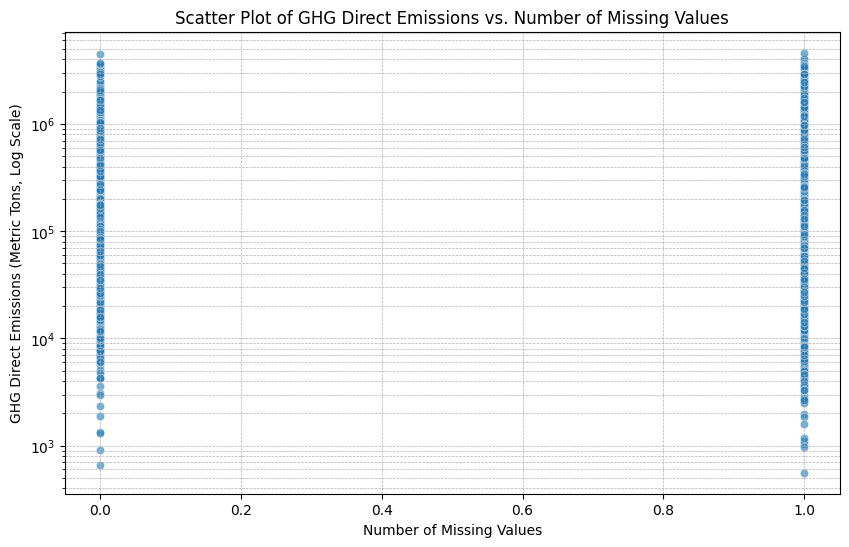

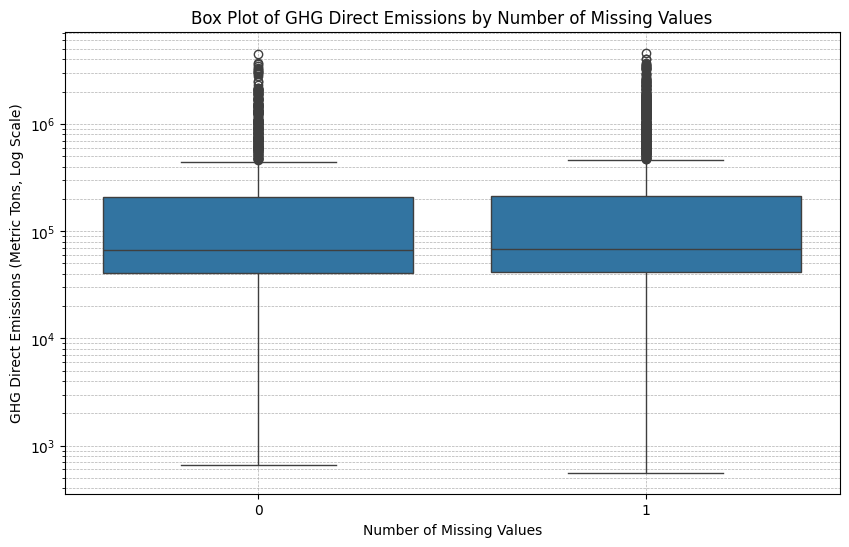

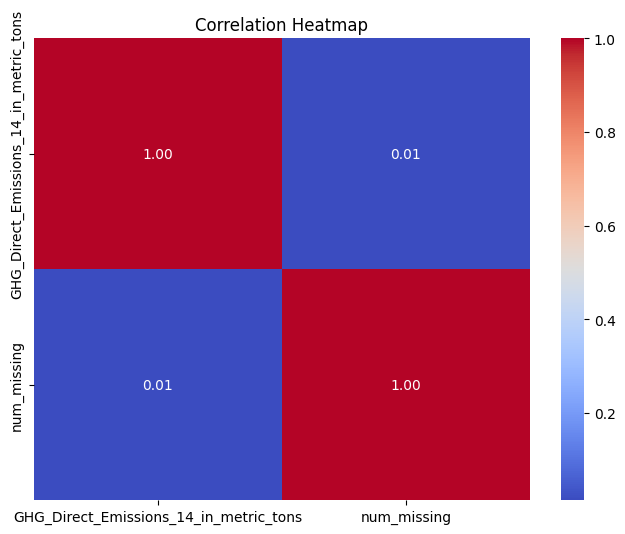

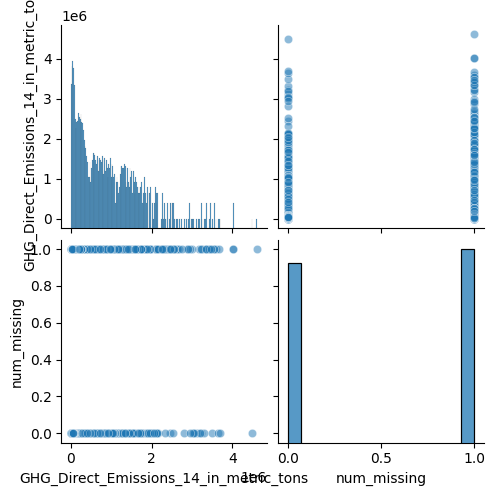

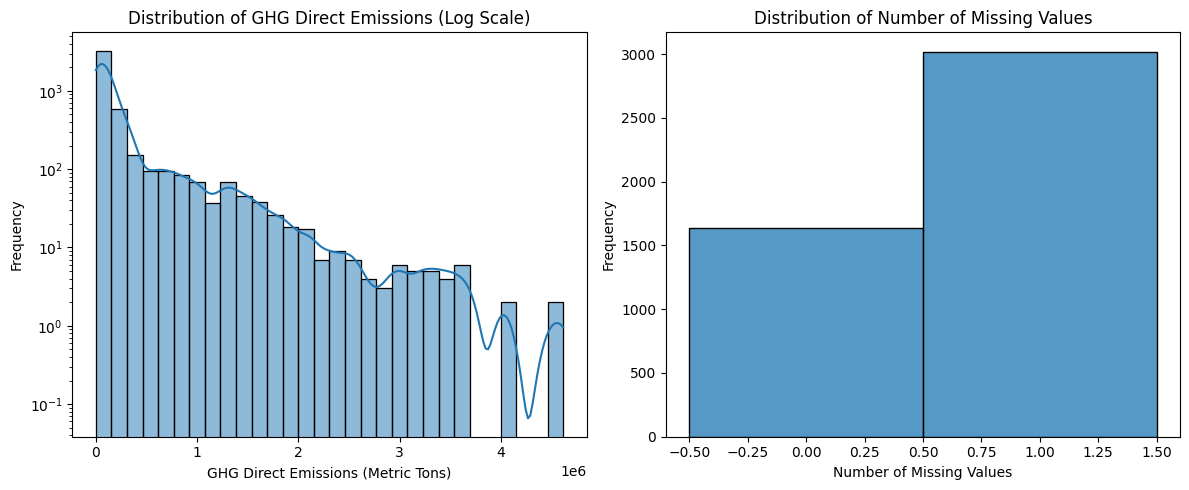

In [417]:

import seaborn as sns
filtered_train_df = train_df[train_df["GHG_Direct_Emissions_14_in_metric_tons"] > 0]
# 1. 散布図（Scatter Plot）
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_train_df,
    x="num_missing",
    y="GHG_Direct_Emissions_14_in_metric_tons",
    alpha=0.6
)
plt.yscale('log')  # Y軸を対数スケールに設定
plt.title("Scatter Plot of GHG Direct Emissions vs. Number of Missing Values")
plt.xlabel("Number of Missing Values")
plt.ylabel("GHG Direct Emissions (Metric Tons, Log Scale)")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

# 2. 箱ひげ図（Box Plot）
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=filtered_train_df,
    x="num_missing",
    y="GHG_Direct_Emissions_14_in_metric_tons"
)
plt.yscale('log')  # Y軸を対数スケールに設定
plt.title("Box Plot of GHG Direct Emissions by Number of Missing Values")
plt.xlabel("Number of Missing Values")
plt.ylabel("GHG Direct Emissions (Metric Tons, Log Scale)")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

# 3. ヒートマップ（Heatmap） - 相関行列の可視化
plt.figure(figsize=(8, 6))
correlation = filtered_train_df[["GHG_Direct_Emissions_14_in_metric_tons", "num_missing"]].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 4. ペアプロット（Pair Plot） - 複数の視点からの可視化
sns.pairplot(filtered_train_df, vars=["GHG_Direct_Emissions_14_in_metric_tons", "num_missing"],
             kind='scatter', plot_kws={'alpha':0.5})
plt.yscale('log')
plt.show()

# 5. ヒストグラム（Histogram） - 各変数の分布
plt.figure(figsize=(12, 5))

# GHG_Direct_Emissions_14_in_metric_tons のヒストグラム（対数スケール）
plt.subplot(1, 2, 1)
sns.histplot(filtered_train_df["GHG_Direct_Emissions_14_in_metric_tons"], bins=30, kde=True)
plt.yscale('log')
plt.title("Distribution of GHG Direct Emissions (Log Scale)")
plt.xlabel("GHG Direct Emissions (Metric Tons)")
plt.ylabel("Frequency")

# num_missing のヒストグラム
plt.subplot(1, 2, 2)
sns.histplot(filtered_train_df["num_missing"], bins=range(filtered_train_df["num_missing"].max()+2), discrete=True, kde=False)
plt.title("Distribution of Number of Missing Values")
plt.xlabel("Number of Missing Values")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [418]:
train_df["less_10^4"] = train_df["GHG_Direct_Emissions_14_in_metric_tons"].apply(lambda x: 1 if x < 10**4 else 0)
target_less_10_4 = train_df["less_10^4"].values



In [419]:
cat0 = CatBoostClassifier(
    iterations=864,
    depth=4,
    learning_rate=0.02,
    l2_leaf_reg=1.2322248317139508,
    border_count=254,
    bagging_temperature=0.1
)

cat0.fit(train, target_less_10_4, verbose=0)
oof_preds = cat0.predict_proba(train)
cat0_pred = cat0.predict_proba(test)

In [420]:
sum(cat0_pred[:, 1] > 0.16)

43

In [421]:
target

array([[ 52973.13994629],
       [ 55910.06661677],
       [ 55679.54321391],
       ...,
       [978359.18321926],
       [ 27234.34120387],
       [194822.07077126]])

In [422]:
tmp = 0
ave_less_10_4_log = 0
max(oof_preds[:, 1])
for i in range(len(oof_preds)):
    if oof_preds[i, 1] > 0.16 and target[i] < 10**4:
        ave_less_10_4_log += np.log1p(target[i])
        tmp += 1

ave_less_10_4_log /= tmp
print(ave_less_10_4_log)
ave_less_10_4 = np.expm1(ave_less_10_4_log)[0]
ave_less_10_4

[8.49499017]


4889.20824708803

In [423]:

def show_plot(test_preds, target, title):
# 共通のビンエッジを定義するため、両方のデータの範囲を取得
    min_val = min(test_preds.min(), target.min())
    max_val = max(test_preds.max(), target.max())

# ビンエッジを共通化（例えば、100ビン）
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

# ヒストグラムを正規化してプロット
    plt.figure(figsize=(7, 5))

# test_preds のヒストグラム
    sns.histplot(test_preds, bins=bins, stat='density', kde=True, color='blue', label='before', alpha=0.6)

# target のヒストグラム
    sns.histplot(target, bins=bins, stat='density', kde=True, color='orange', label='after', alpha=0.6)

# ログスケールを適用
    plt.xscale('log')

# ラベルとタイトルの設定
    plt.xlabel('Values (Log Scale)')
    plt.ylabel('Density')
    plt.title(title)

# 凡例の表示
    plt.legend()

# グリッドの追加（オプション）
    plt.grid(True, which="both", ls="--", linewidth=0.5)

# プロットの表示
    plt.show()


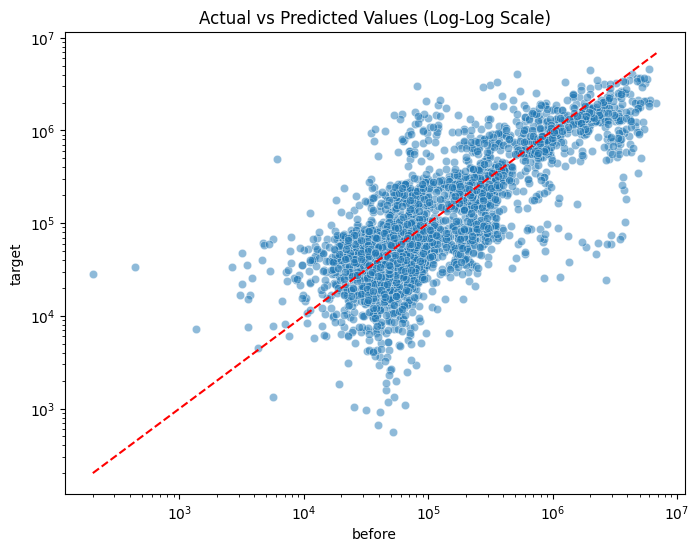

In [424]:

x=train_df["GHG_Direct_Emissions_12_in_metric_tons"]
y=train_df["GHG_Direct_Emissions_14_in_metric_tons"]
# 実測値と予測値を対数スケールでプロット
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('before')
plt.ylabel('target')
plt.title('Actual vs Predicted Values (Log-Log Scale)')
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')  # 45度線
plt.show()

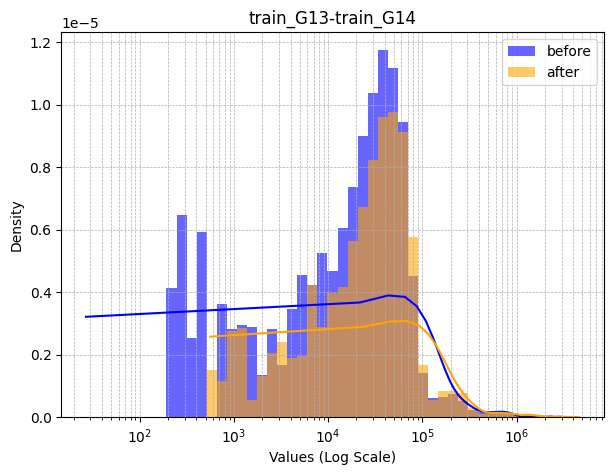

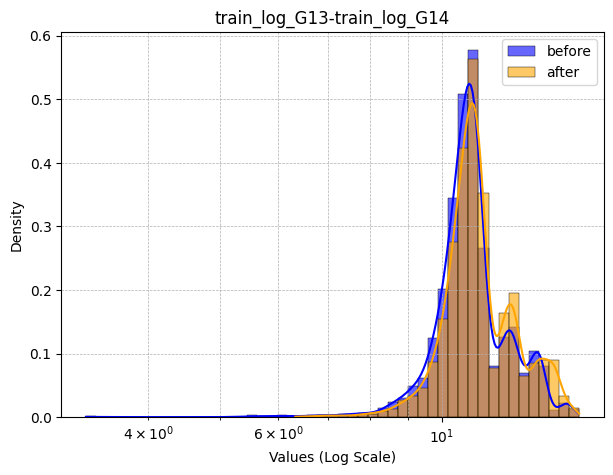

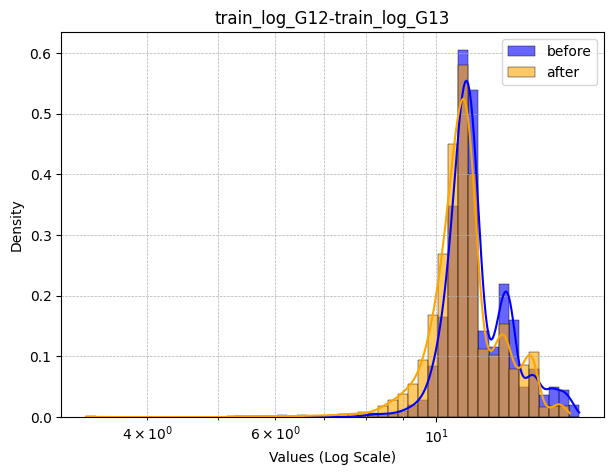

In [425]:

show_plot(train_df["GHG_Direct_Emissions_13_in_metric_tons"],
          train_df["GHG_Direct_Emissions_14_in_metric_tons"],
          "train_G13-train_G14")
show_plot(np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
          np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons"]),
          "train_log_G13-train_log_G14")
show_plot(np.log(train_df["GHG_Direct_Emissions_12_in_metric_tons"]),
          np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
          "train_log_G12-train_log_G13")


In [426]:
from itertools import combinations

def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))

    # エラーの累計を保持する辞書
    sum_error = {}
    # 各組み合わせの選択回数を保持する辞書
    combination_count = {}

    # 個別モデルの名前リスト
    model_names = ["model1", "model2", "model3", "model4"]

    # 全ての組み合わせを生成（1, 2, 3, 4モデル）
    all_combinations = []
    for r in range(1, 5):
        all_combinations.extend(combinations(model_names, r))

    # 初期化
    for comb in all_combinations:
        sum_error[comb] = 0
        combination_count[comb] = 0

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"Starting Fold {fold + 1}")
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # モデルと損失の初期化
        model_dict = {}
        loss_dict = {}
        valid_pred_dict = {}

        # モデル1: XGBRegressor
        params1 = {
            "n_estimators": 626,
            "max_depth": 3,
            "random_state": 13,
            "min_child_weight": 0.001190123543553736,
            "learning_rate": 0.010519736270936835,
            "subsample": 0.7304788478701394,
            "colsample_bylevel": 0.604447278915981,
            "colsample_bytree": 0.7616852136157319,
            "reg_alpha": 0.115175569924065,
            "reg_lambda": 0.07155347824929895
        }
        model1 = XGBRegressor(**params1)

        # モデル2: CatBoostRegressor
        params                       = {"n_estimators": 56,"random_state":13,
                                         "verbose":-1,}
        model2                       = LGBMRegressor(**params)

        # モデル3: XGBRegressor
        params3 ={
            "n_estimators": 897,
            "max_depth": 4,
            "min_child_weight": 1.9636282677053687,
            "learning_rate": 0.006151391207761763,
            "subsample": 0.8251910979922186,
            "colsample_bylevel": 0.6454805596196158,
            "colsample_bytree": 0.598042694363472,
            "reg_alpha": 2.1719824223479005,
            "reg_lambda": 0.009192236594241635,
        }
        model3 = XGBRegressor(**params3)

        # モデル4: CatBoostRegressor
        params4 = {
            "iterations": 940,
            "depth": 3,
            "learning_rate": 0.019908189422344794,
            "l2_leaf_reg": 1,
            "bagging_temperature": 0.5063893392618839,
            "min_data_in_leaf": 1,
            'random_state': 42
        }
        model4 = CatBoostRegressor(**params4, verbose=0)

        # 各モデルの訓練と予測
        models = {
            "model1": model1,
            "model2": model2,
            "model3": model3,
            "model4": model4
        }

        for name, model in models.items():
            model.fit(X_train, np.log1p(y_train))
            preds = np.expm1(model.predict(X_valid))
            rmsle = np.sqrt(mean_squared_log_error(y_valid, preds))
            print(f"Fold {fold + 1} RMSLE for {name} = {rmsle}")
            loss_dict[name] = rmsle
            valid_pred_dict[name] = preds
            sum_error[(name,)] += rmsle

        # すべての2モデルおよび3モデルの組み合わせを評価
        for r in [2, 3]:
            for comb in combinations(model_names, r):
                # 平均予測
                preds_comb = np.mean([valid_pred_dict[model] for model in comb], axis=0)
                rmsle_comb = np.sqrt(mean_squared_log_error(y_valid, preds_comb))
                print(f"Fold {fold + 1} RMSLE for {comb} = {rmsle_comb}")
                loss_dict[comb] = rmsle_comb
                valid_pred_dict[comb] = preds_comb
                sum_error[comb] += rmsle_comb

        # 全モデルのアンサンブル
        preds_all = np.mean([valid_pred_dict[model] for model in model_names], axis=0)
        rmsle_all = np.sqrt(mean_squared_log_error(y_valid, preds_all))
        print(f"Fold {fold + 1} RMSLE for all models ensemble = {rmsle_all}")
        loss_dict[tuple(model_names)] = rmsle_all
        valid_pred_dict[tuple(model_names)] = preds_all
        sum_error[tuple(model_names)] += rmsle_all

        # 最適な組み合わせを選択
        best_combination = min(loss_dict, key=loss_dict.get)
        best_rmsle = loss_dict[best_combination]
        print(f"Fold {fold + 1} best combination: {best_combination} with RMSLE = {best_rmsle}")


        # OOF予測とテスト予測の更新
        if isinstance(best_combination, tuple):
            # 複数モデルのアンサンブル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = np.mean([models[model].predict(test) for model in best_combination], axis=0)
        else:
            # 単一モデル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = models[best_combination].predict(test)

        test_predictions += test_preds / kf.n_splits

        # メモリの解放
        del X_train, X_valid, y_train, y_valid, model1, model2, model3, model4
        gc.collect()

        print('---------------\n')

    # 最終的なOOF RMSLEの計算
    final_RMSLE = np.sqrt(mean_squared_log_error(target, oof_predictions))
    print(f"OOF RMSLE = {final_RMSLE}")

    # テスト予測の逆変換
    final_test_predictions = np.expm1(test_predictions)

    # 各組み合わせの累積エラーと選択回数を表示
    print("Sum of RMSLE for each combination:")
    for comb, error in sum_error.items():
        print(f"{comb}: {error}")

    # print("\nNumber of times each combination was selected:")
    # for comb, count in combination_count.items():
    #     print(f"{comb}: {count}")

    return oof_predictions, final_test_predictions

In [427]:
oof_predictions,test_preds = get_models_trained(train,test,target,30)

Starting Fold 1
Fold 1 RMSLE for model1 = 0.6748432956893732
Fold 1 RMSLE for model2 = 0.685226641461286
Fold 1 RMSLE for model3 = 0.6726295586656458
Fold 1 RMSLE for model4 = 0.6804740674550488
Fold 1 RMSLE for ('model1', 'model2') = 0.6760323400216317
Fold 1 RMSLE for ('model1', 'model3') = 0.673438823916687
Fold 1 RMSLE for ('model1', 'model4') = 0.6757580527573754
Fold 1 RMSLE for ('model2', 'model3') = 0.67548649028672
Fold 1 RMSLE for ('model2', 'model4') = 0.6782449317968401
Fold 1 RMSLE for ('model3', 'model4') = 0.6747026697803885
Fold 1 RMSLE for ('model1', 'model2', 'model3') = 0.6741367990936445
Fold 1 RMSLE for ('model1', 'model2', 'model4') = 0.675478742104954
Fold 1 RMSLE for ('model1', 'model3', 'model4') = 0.6742335405348721
Fold 1 RMSLE for ('model2', 'model3', 'model4') = 0.6750077958158676
Fold 1 RMSLE for all models ensemble = 0.6742658172685644
Fold 1 best combination: model3 with RMSLE = 0.6726295586656458
---------------

Starting Fold 2
Fold 2 RMSLE for model1 

In [428]:
train_tmp_df = train_df[numerical_columns+
                 lat_lon_columns+
                #  categorical_columns+
                 new_features1+['Economic_Sector']
                #  new_features2
               #   new_features3+
                #  train_aggregations+
               #   neighbour_feats
                 +["num_missing"]+
                  ["GHG_Direct_Emissions_14_in_metric_tons"]
                 ]
test_tmp_df  = test_df[numerical_columns+
                 lat_lon_columns+
                #  categorical_columns+
                 new_features1+['Economic_Sector']
                #  new_features2
               #   new_features3+
                #  train_aggregations+
               #   neighbour_feats
                +["num_missing"]
                   ]
target = train_df[target_columns]
oof_predictions_pd = pd.DataFrame(oof_predictions, columns=["oof_predictions"])
test_preds_pd = pd.DataFrame(test_preds, columns=["test_preds"])
test_preds_pd = pd.DataFrame(test_preds, columns=["test_preds"])
train_df_1 = pd.concat([train_tmp_df, oof_predictions_pd], axis=1)
train_all_df = pd.concat([train_df_1, target], axis=1)
test_all_df = pd.concat([test_tmp_df, test_preds_pd], axis=1)

In [429]:
test_all_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,test_preds
0,NaN,NaN,NaN,NaN,4,"88,951","65,803","28,993","32,965",38,-98,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"43,660"
1,NaN,NaN,NaN,NaN,221,NaN,NaN,"311,926","268,668",32,-109,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"318,432"
2,"28,275","32,075","26,446","23,385",130,"84,908","6,213","34,733","39,045",41,-79,"3,800","-5,629","-3,061",0,-0,-0,8,0,"40,603"
3,"37,330","42,504","43,906","42,958",82,"49,005",52,"14,262","20,205",45,-93,"5,174","1,402",-948,0,0,-0,8,0,"27,603"
4,"45,311","39,898","40,203","39,437",181,"84,960","15,351","40,007","63,935",33,-117,"-5,413",306,-766,-0,0,-0,8,0,"47,078"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"549,795"
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"113,768"
2505,"22,956","23,592","25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"141,266"
2506,"124,461","140,816","93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"259,996"


In [430]:
train_df

,Latitude,Longitude,City,State,County,FIPScode,PrimaryNAICS,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons,Economic_Sector,Economy_Sector_Weighted_Avg,Economic_Sector_Average,Nearest_Weighted_Average,Nearest_Average,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,GHG_Direct_Emissions_YoY_Change_11,GHG_Direct_Emissions_YoY_Change_12,GHG_Direct_Emissions_YoY_Change_13,GHG_Direct_Emissions_Growth_Rate_11,GHG_Direct_Emissions_Growth_Rate_12,GHG_Direct_Emissions_Growth_Rate_13,TRI_to_GHG_Ratio_10,TRI_to_GHG_Ratio_11,TRI_to_GHG_Ratio_12,TRI_to_GHG_Ratio_13,GHG_Direct_Emissions_14_in_metric_tons_mean,GHG_Direct_Emissions_14_in_metric_tons_median,GHG_Direct_Emissions_14_in_metric_tons_max,GHG_Direct_Emissions_14_in_metric_tons_min,GHG_Direct_Emissions_14_in_metric_tons_count,num_missing,less_10^4
0,40,-88,760,15,1210,404,118,"31,567","26,645","23,410","31,810","64,817","36,589","37,908","45,598","52,973",8,"5,398","47,190","9,792","33,589","-4,922","-3,235","8,399",-0,-0,0,"-28,228","1,319","7,690",-0,0,0,0,1,1,1,"224,420","58,246","3,115,016","4,809",65,0,0
1,38,-81,596,52,580,1812,221,NaN,NaN,NaN,NaN,"55,508","72,387","58,225","76,377","55,910",14,"162,818","400,093","148,763","132,465",NaN,NaN,NaN,NaN,NaN,NaN,"16,880","-14,162","18,151",0,-0,0,NaN,NaN,NaN,NaN,"237,021","170,271","662,510","38,397",10,1,0
2,39,-81,1267,52,971,1831,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"55,680",9,"103,978","417,285","218,812","483,238",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"142,552","63,549","1,509,645","10,597",44,1,0
3,35,-119,158,4,597,118,21,NaN,NaN,NaN,NaN,"54,811","69,340","63,647","53,799","61,412",15,"131,971","103,867","131,971","103,867",NaN,NaN,NaN,NaN,NaN,NaN,"14,529","-5,693","-9,848",0,-0,-0,NaN,NaN,NaN,NaN,"247,799","67,578","2,486,906","4,179",98,1,0
4,42,-82,598,36,289,1206,21,"29,554","28,338","30,841","25,154","81,812","53,824","77,391","17,663","43,100",15,"13,381","32,692","59,477","94,821","-1,216","2,503","-5,687",-0,0,-0,"-27,989","23,568","-59,728",-0,0,-1,0,1,0,1,"180,513","45,651","2,126,404","12,939",26,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,33,-97,3123,45,570,1588,3,NaN,NaN,NaN,NaN,"54,979","56,464","3,522,786","76,643","2,451,197",9,"180,502","330,575","116,105","145,932",NaN,NaN,NaN,NaN,NaN,NaN,"1,485","3,466,322","-3,446,143",0,61,-1,NaN,NaN,NaN,NaN,"292,116","66,395","3,422,654","3,292",184,1,0
4651,43,-110,2382,53,1135,1898,3,NaN,NaN,NaN,NaN,"208,375","57,067","48,580","26,892","35,740",9,"54,998","348,658","54,998","348,658",NaN,NaN,NaN,NaN,NaN,NaN,"-151,309","-8,486","-21,688",-1,-0,-0,NaN,NaN,NaN,NaN,"297,602","67,780","2,990,948","14,635",44,1,0
4652,35,-97,2231,37,842,1301,244,NaN,NaN,NaN,NaN,"563,756","598,881","1,665,103","543,206","978,359",5,672,"62,160","36,607","103,844",NaN,NaN,NaN,NaN,NaN,NaN,"35,125","1,066,222","-1,121,897",0,2,-1,NaN,NaN,NaN,NaN,"978,359","978,359","978,359","978,359",1,1,0
4653,39,-76,1533,21,486,718,241,NaN,NaN,NaN,NaN,"67,451","27,398","39,228","46,635","27,234",1,"28,225","107,929","22,104","56,751",NaN,NaN,NaN,NaN,NaN,NaN,"-40,053","11,830","7,407",-1,0,0,NaN,NaN,NaN,NaN,"281,591","98,075","1,295,239","10,230",22,1,0


In [431]:
train_all_df.to_csv("train_all_df.csv", index=False)
test_all_df.to_csv("test_all_df.csv", index=False)

In [432]:
path  = "/content/drive/My Drive/signate/SMBC Group GREEN×DATA Challenge 2024/"
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv('train_all_df.csv', index_col=0)

train_df.drop("GHG_Direct_Emissions_14_in_metric_tons", axis=1, inplace=True)
# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv('test_all_df.csv', index_col=0)

In [433]:
# すべての列を表示するように設定
pd.set_option('display.max_columns', None)
train_df.columns

Index(['TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs',
       'TRI_Air_Emissions_13_in_lbs', 'PrimaryNAICS',
       'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing', 'oof_predictions',
       'GHG_Direct_Emissions_14_in_metric_tons.1'],
      dtype='object')

In [434]:
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

In [435]:
train_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1
0,"26,645","23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"38,681","52,973"
1,NaN,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"64,211","55,910"
2,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"109,222","55,680"
3,NaN,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"51,154","61,412"
4,"28,338","30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"52,716","43,100"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,NaN,NaN,NaN,3,"54,979","56,464","3,522,786","76,643",33,-97,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"222,025","2,451,197"
4651,NaN,NaN,NaN,3,"208,375","57,067","48,580","26,892",43,-110,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"50,370","35,740"
4652,NaN,NaN,NaN,244,"563,756","598,881","1,665,103","543,206",35,-97,NaN,NaN,NaN,NaN,NaN,NaN,5,1,"1,211,018","978,359"
4653,NaN,NaN,NaN,241,"67,451","27,398","39,228","46,635",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"39,963","27,234"


In [436]:

def show_plot(test_preds, target, title):
# 共通のビンエッジを定義するため、両方のデータの範囲を取得
    min_val = min(test_preds.min(), target.min())
    max_val = max(test_preds.max(), target.max())

# ビンエッジを共通化（例えば、100ビン）
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

# ヒストグラムを正規化してプロット
    plt.figure(figsize=(7, 5))

# test_preds のヒストグラム
    sns.histplot(test_preds, bins=bins, stat='density', kde=True, color='blue', label='before', alpha=0.6)

# target のヒストグラム
    sns.histplot(target, bins=bins, stat='density', kde=True, color='orange', label='after', alpha=0.6)

# ログスケールを適用
    plt.xscale('log')

# ラベルとタイトルの設定
    plt.xlabel('Values (Log Scale)')
    plt.ylabel('Density')
    plt.title(title)

# 凡例の表示
    plt.legend()

# グリッドの追加（オプション）
    plt.grid(True, which="both", ls="--", linewidth=0.5)

# プロットの表示
    plt.show()


In [437]:
train_all_df = pd.concat([train_df, test_df], axis=0)
train_all_df["GHG_Direct_Emissions_14_in_metric_tons.1"][len(train_df):] = test_df["test_preds"]
print(train_all_df.columns)
train_all_df.drop('test_preds', axis=1, inplace=True)

test_df.drop('test_preds', axis=1, inplace=True)

Index(['TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs',
       'TRI_Air_Emissions_13_in_lbs', 'PrimaryNAICS',
       'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing', 'oof_predictions',
       'GHG_Direct_Emissions_14_in_metric_tons.1', 'test_preds'],
      dtype='object')


In [438]:
# 1. RMSLEの計算（ベクトル化）
# 'test_preds' と 'oof_predictions' を明示的に指定
diff = abs(np.log1p(train_all_df['GHG_Direct_Emissions_14_in_metric_tons.1']) - np.log1p(train_all_df['oof_predictions']))

# 2. 条件を満たす行のマスクを作成
mask = diff > 0.72
# 3. 除外する行の数をカウント
exclude_num = mask.sum()
train_df = train_all_df.copy()
# 4. 条件を満たさない行だけを保持
train_not_mask_df = train_all_df[~mask].reset_index(drop=True)
train_mask_df = train_all_df[mask].reset_index(drop=True)

# 5. 'oof_predictions' 列を削除
train_not_mask_df.drop('oof_predictions', axis=1, inplace=True)
train_mask_df.drop('oof_predictions', axis=1, inplace=True)
train_df.drop('oof_predictions', axis=1, inplace=True)
# 6. 結果の表示
print(f"除外された行数: {exclude_num}")

除外された行数: 1118


In [439]:
train_not_mask_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1
0,"26,645","23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"52,973"
1,NaN,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"55,910"
2,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"55,680"
3,NaN,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"61,412"
4,"28,338","30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"43,100"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"549,795"
6041,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"113,768"
6042,"23,592","25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"141,266"
6043,"140,816","93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"259,996"


'iterations': 254, 'depth': 5, 'learning_rate': 0.08377009991199288, 'l2_leaf_reg': 1, 'bagging_temperature': 0.7204457890870082, 'min_data_in_leaf': 4

In [440]:
from itertools import combinations

def get_models_trained(train, test, target, num_folds, train_eval):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_eval_predictions = np.zeros(len(train_eval))

    # エラーの累計を保持する辞書
    sum_error = {}
    # 各組み合わせの選択回数を保持する辞書
    combination_count = {}

    # 個別モデルの名前リスト
    model_names = ["model1", "model2", "model3", "model4"]

    # 全ての組み合わせを生成（1, 2, 3, 4モデル）
    all_combinations = []
    for r in range(1, 5):
        all_combinations.extend(combinations(model_names, r))

    # 初期化
    for comb in all_combinations:
        sum_error[comb] = 0
        combination_count[comb] = 0

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"Starting Fold {fold + 1}")
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # モデルと損失の初期化
        model_dict = {}
        loss_dict = {}
        valid_pred_dict = {}

        # モデル1: XGBRegressor
        params1 = {
            "n_estimators": 626,
            "max_depth": 3,
            "random_state": 13,
            "min_child_weight": 0.001190123543553736,
            "learning_rate": 0.010519736270936835,
            "subsample": 0.7304788478701394,
            "colsample_bylevel": 0.604447278915981,
            "colsample_bytree": 0.7616852136157319,
            "reg_alpha": 0.115175569924065,
            "reg_lambda": 0.07155347824929895
        }
        model1 = XGBRegressor(**params1)

        # モデル2: CatBoostRegressor
        params                       = {'iterations': 254,
                                        'depth': 5,
                                        'learning_rate': 0.08377009991199288,
                                        'l2_leaf_reg': 1,
                                        'bagging_temperature': 0.7204457890870082,
                                        'min_data_in_leaf': 4,
                                        "random_state":13,
                                         "verbose":0}
        model2                       = CatBoostRegressor(**params)

        # モデル3: XGBRegressor
        params3 ={
            "n_estimators": 897,
            "max_depth": 4,
            "min_child_weight": 1.9636282677053687,
            "learning_rate": 0.006151391207761763,
            "subsample": 0.8251910979922186,
            "colsample_bylevel": 0.6454805596196158,
            "colsample_bytree": 0.598042694363472,
            "reg_alpha": 2.1719824223479005,
            "reg_lambda": 0.009192236594241635,
        }
        model3 = XGBRegressor(**params3)

        # モデル4: CatBoostRegressor
        params4 = {
            "iterations": 940,
            "depth": 3,
            "learning_rate": 0.019908189422344794,
            "l2_leaf_reg": 1,
            "bagging_temperature": 0.5063893392618839,
            "min_data_in_leaf": 1,
            'random_state': 42
        }
        model4 = CatBoostRegressor(**params4, verbose=0)

        # 各モデルの訓練と予測
        models = {
            "model1": model1,
            "model2": model2,
            "model3": model3,
            "model4": model4
        }

        for name, model in models.items():
            model.fit(X_train, np.log1p(y_train))
            preds = np.expm1(model.predict(X_valid))
            rmsle = np.sqrt(mean_squared_log_error(y_valid, preds))
            print(f"Fold {fold + 1} RMSLE for {name} = {rmsle}")
            loss_dict[name] = rmsle
            valid_pred_dict[name] = preds
            sum_error[(name,)] += rmsle

        # すべての2モデルおよび3モデルの組み合わせを評価
        for r in [2, 3]:
            for comb in combinations(model_names, r):
                # 平均予測
                preds_comb = np.mean([valid_pred_dict[model] for model in comb], axis=0)
                rmsle_comb = np.sqrt(mean_squared_log_error(y_valid, preds_comb))
                print(f"Fold {fold + 1} RMSLE for {comb} = {rmsle_comb}")
                loss_dict[comb] = rmsle_comb
                valid_pred_dict[comb] = preds_comb
                sum_error[comb] += rmsle_comb

        # 全モデルのアンサンブル
        preds_all = np.mean([valid_pred_dict[model] for model in model_names], axis=0)
        rmsle_all = np.sqrt(mean_squared_log_error(y_valid, preds_all))
        print(f"Fold {fold + 1} RMSLE for all models ensemble = {rmsle_all}")
        loss_dict[tuple(model_names)] = rmsle_all
        valid_pred_dict[tuple(model_names)] = preds_all
        sum_error[tuple(model_names)] += rmsle_all

        # 最適な組み合わせを選択
        best_combination = min(loss_dict, key=loss_dict.get)
        best_rmsle = loss_dict[best_combination]
        print(f"Fold {fold + 1} best combination: {best_combination} with RMSLE = {best_rmsle}")


        # OOF予測とテスト予測の更新
        if isinstance(best_combination, tuple):
            # 複数モデルのアンサンブル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = np.mean([models[model].predict(test) for model in best_combination], axis=0)
            train_eval_preds = np.mean([models[model].predict(train_eval) for model in best_combination], axis=0)
        else:
            # 単一モデル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = models[best_combination].predict(test)
            train_eval_preds = models[best_combination].predict(train_eval)

        # 各組み合わせの選択回数をインクリメント
        # combination_count[best_combination] += 1

        test_predictions += test_preds / kf.n_splits
        train_eval_predictions += train_eval_preds/ kf.n_splits

        # メモリの解放
        del X_train, X_valid, y_train, y_valid, model1, model2, model3, model4
        gc.collect()

        print('---------------\n')

    # 最終的なOOF RMSLEの計算
    final_RMSLE = np.sqrt(mean_squared_log_error(target, oof_predictions))
    print(f"OOF RMSLE = {final_RMSLE}")

    # テスト予測の逆変換
    final_test_predictions = np.expm1(test_predictions)
    final_train_predictions = np.expm1(train_eval_predictions)

    # 各組み合わせの累積エラーと選択回数を表示
    print("Sum of RMSLE for each combination:")
    for comb, error in sum_error.items():
        print(f"{comb}: {error}")

    # print("\nNumber of times each combination was selected:")
    # for comb, count in combination_count.items():
    #     print(f"{comb}: {count}")

    return oof_predictions, final_test_predictions, final_train_predictions

In [441]:
train_not_mask_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1
0,"26,645","23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"52,973"
1,NaN,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"55,910"
2,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"55,680"
3,NaN,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"61,412"
4,"28,338","30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"43,100"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"549,795"
6041,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"113,768"
6042,"23,592","25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"141,266"
6043,"140,816","93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"259,996"


In [442]:
train_not_mask = train_not_mask_df.iloc[:, :-1].values
train_mask = train_mask_df.iloc[:, :-1].values
train_not_mask_target = train_not_mask_df.iloc[:, -1].values
train_mask_target = train_mask_df.iloc[:, -1].values
test = test_df.values

In [443]:
oof_predictions,test_preds, train_mask_preds = get_models_trained(train_not_mask,test,train_not_mask_target,30, train_mask)

Starting Fold 1
Fold 1 RMSLE for model1 = 0.28887469493953233
Fold 1 RMSLE for model2 = 0.2798689812987604
Fold 1 RMSLE for model3 = 0.28697679521152775
Fold 1 RMSLE for model4 = 0.28401873203735073
Fold 1 RMSLE for ('model1', 'model2') = 0.28184710620111536
Fold 1 RMSLE for ('model1', 'model3') = 0.2875125978421929
Fold 1 RMSLE for ('model1', 'model4') = 0.2846132430338378
Fold 1 RMSLE for ('model2', 'model3') = 0.2810387181297564
Fold 1 RMSLE for ('model2', 'model4') = 0.2805575452372724
Fold 1 RMSLE for ('model3', 'model4') = 0.28345753562896536
Fold 1 RMSLE for ('model1', 'model2', 'model3') = 0.28286192068492516
Fold 1 RMSLE for ('model1', 'model2', 'model4') = 0.2817313058753606
Fold 1 RMSLE for ('model1', 'model3', 'model4') = 0.28469379756749486
Fold 1 RMSLE for ('model2', 'model3', 'model4') = 0.2810556054226778
Fold 1 RMSLE for all models ensemble = 0.28229487476972676
Fold 1 best combination: model2 with RMSLE = 0.2798689812987604
---------------

Starting Fold 2
Fold 2 RMSL

In [444]:
train_df = train_df.reset_index(drop=True)
train_df.iloc[:, -1]

,GHG_Direct_Emissions_14_in_metric_tons.1
0,"52,973"
1,"55,910"
2,"55,680"
3,"61,412"
4,"43,100"
...,...
7158,"549,795"
7159,"113,768"
7160,"141,266"
7161,"259,996"


In [445]:
# print(type(train_not_mask_df), type(oof_predictions))
# oof_predictions_series = pd.Series(oof_predictions, name='oof_predictions')
# train_not_mask_all_df = pd.concat([train_not_mask_df, oof_predictions], axis=1)
# train_not_mask_all_df.iloc[:, -1]

train_not_mask_df["oof_predictions"] = oof_predictions
train_mask_df["oof_predictions"] = train_mask_preds
train_all_df = pd.concat([train_not_mask_df, train_mask_df], axis=0)
test_df["test_preds"] = test_preds
train_all_df = train_all_df[:len(train_df)-exclude_num]
train_all_df.to_csv("train_all_df_054.csv")
test_df.to_csv("test_all_df_054.csv")

In [446]:
train_all_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1,oof_predictions
0,"26,645","23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"52,973","41,547"
1,NaN,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"55,910","59,347"
2,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"55,680","99,121"
3,NaN,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"61,412","51,450"
4,"28,338","30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"43,100","51,060"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"549,795","542,859"
6041,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"113,768","99,087"
6042,"23,592","25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"141,266","135,588"
6043,"140,816","93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"259,996","258,543"


In [447]:
test_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,test_preds
0,NaN,NaN,NaN,4,"88,951","65,803","28,993","32,965",38,-98,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"44,594"
1,NaN,NaN,NaN,221,NaN,NaN,"311,926","268,668",32,-109,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"296,645"
2,"32,075","26,446","23,385",130,"84,908","6,213","34,733","39,045",41,-79,"3,800","-5,629","-3,061",0,-0,-0,8,0,"41,032"
3,"42,504","43,906","42,958",82,"49,005",52,"14,262","20,205",45,-93,"5,174","1,402",-948,0,0,-0,8,0,"30,125"
4,"39,898","40,203","39,437",181,"84,960","15,351","40,007","63,935",33,-117,"-5,413",306,-766,-0,0,-0,8,0,"47,570"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"523,079"
2504,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"100,312"
2505,"23,592","25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"134,940"
2506,"140,816","93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"262,619"


In [456]:
path  = "/content/drive/My Drive/signate/SMBC Group GREEN×DATA Challenge 2024/"
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv('train_all_df_054.csv', index_col = 0)

# train_df.drop("GHG_Direct_Emissions_14_in_metric_tons", axis=1, inplace=True)
# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv('test_all_df_054.csv', index_col=0)

In [457]:
# すべての列を表示するように設定
pd.set_option('display.max_columns', None)
train_df.columns

Index(['TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs',
       'TRI_Air_Emissions_13_in_lbs', 'PrimaryNAICS',
       'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing',
       'GHG_Direct_Emissions_14_in_metric_tons.1', 'oof_predictions'],
      dtype='object')

In [458]:
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

In [459]:
train_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1,oof_predictions
0,"26,645","23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"52,973","41,547"
1,NaN,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"55,910","59,347"
2,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"55,680","99,121"
3,NaN,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"61,412","51,450"
4,"28,338","30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"43,100","51,060"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"549,795","542,859"
6041,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"113,768","99,087"
6042,"23,592","25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"141,266","135,588"
6043,"140,816","93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"259,996","258,543"


データの欠損あり.

In [460]:

def show_plot(test_preds, target, title):
# 共通のビンエッジを定義するため、両方のデータの範囲を取得
    min_val = min(test_preds.min(), target.min())
    max_val = max(test_preds.max(), target.max())

# ビンエッジを共通化（例えば、100ビン）
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

# ヒストグラムを正規化してプロット
    plt.figure(figsize=(7, 5))

# test_preds のヒストグラム
    sns.histplot(test_preds, bins=bins, stat='density', kde=True, color='blue', label='before', alpha=0.6)

# target のヒストグラム
    sns.histplot(target, bins=bins, stat='density', kde=True, color='orange', label='after', alpha=0.6)

# ログスケールを適用
    plt.xscale('log')

# ラベルとタイトルの設定
    plt.xlabel('Values (Log Scale)')
    plt.ylabel('Density')
    plt.title(title)

# 凡例の表示
    plt.legend()

# グリッドの追加（オプション）
    plt.grid(True, which="both", ls="--", linewidth=0.5)

# プロットの表示
    plt.show()


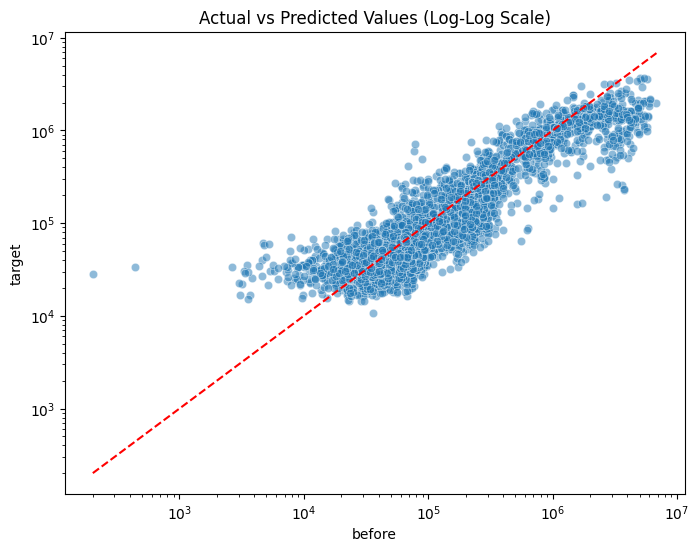

In [461]:

x=train_df["GHG_Direct_Emissions_12_in_metric_tons"]
y=train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
# 実測値と予測値を対数スケールでプロット
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('before')
plt.ylabel('target')
plt.title('Actual vs Predicted Values (Log-Log Scale)')
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')  # 45度線
plt.show()

In [462]:
train_all_df = pd.concat([train_df, test_df], axis=0)
train_all_df["GHG_Direct_Emissions_14_in_metric_tons.1"][len(train_df):] = test_df["test_preds"]
print(train_all_df.columns)
train_all_df.drop('test_preds', axis=1, inplace=True)

test_df.rename(columns={'test_preds': 'oof_predictions'}, inplace=True)

Index(['TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs',
       'TRI_Air_Emissions_13_in_lbs', 'PrimaryNAICS',
       'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing',
       'GHG_Direct_Emissions_14_in_metric_tons.1', 'oof_predictions',
       'test_preds'],
      dtype='object')


In [463]:
train_all_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1,oof_predictions
0,"26,645","23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"52,973","41,547"
1,NaN,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"55,910","59,347"
2,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"55,680","99,121"
3,NaN,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"61,412","51,450"
4,"28,338","30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"43,100","51,060"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"523,079",NaN
2504,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"100,312",NaN
2505,"23,592","25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"134,940",NaN
2506,"140,816","93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"262,619",NaN


In [464]:
train_all_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1,oof_predictions
0,"26,645","23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"52,973","41,547"
1,NaN,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"55,910","59,347"
2,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"55,680","99,121"
3,NaN,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"61,412","51,450"
4,"28,338","30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"43,100","51,060"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"523,079",NaN
2504,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"100,312",NaN
2505,"23,592","25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"134,940",NaN
2506,"140,816","93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"262,619",NaN


In [465]:
len(train_df), len(train_all_df), len(test_df)

(6045, 8553, 2508)

In [466]:
# 1. RMSLEの計算（ベクトル化）
# 'test_preds' と 'oof_predictions' を明示的に指定
diff = np.log1p(train_all_df['GHG_Direct_Emissions_14_in_metric_tons.1']) - np.log1p(train_all_df['oof_predictions'])
train_all_df['diff'] = diff
train_df = train_all_df[:len(train_df)]
test_df = train_all_df[len(train_df):]

In [467]:
train_all_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1,oof_predictions,diff
0,"26,645","23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"52,973","41,547",0
1,NaN,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"55,910","59,347",-0
2,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"55,680","99,121",-1
3,NaN,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"61,412","51,450",0
4,"28,338","30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"43,100","51,060",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"523,079",NaN,NaN
2504,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"100,312",NaN,NaN
2505,"23,592","25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"134,940",NaN,NaN
2506,"140,816","93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"262,619",NaN,NaN


In [468]:
train_all_df["oof_predictions"].fillna(train_all_df["GHG_Direct_Emissions_14_in_metric_tons.1"], inplace=True)
train_all_df["diff"].fillna(0, inplace=True)

In [469]:
train_all_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)
train_df_GHG14 = train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
train_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)

In [470]:
test_df["oof_predictions"] = test_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
test_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)

In [471]:
from itertools import combinations

def get_models_trained(train, test, target, num_folds, train_eval):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_eval_predictions = np.zeros(len(train_eval))

    # エラーの累計を保持する辞書
    sum_error = {}
    # 各組み合わせの選択回数を保持する辞書
    combination_count = {}

    # 個別モデルの名前リスト
    model_names = ["model1", "model2", "model3", "model4"]

    # 全ての組み合わせを生成（1, 2, 3, 4モデル）
    all_combinations = []
    for r in range(1, 5):
        all_combinations.extend(combinations(model_names, r))

    # 初期化
    for comb in all_combinations:
        sum_error[comb] = 0
        combination_count[comb] = 0

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"Starting Fold {fold + 1}")
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # モデルと損失の初期化
        model_dict = {}
        loss_dict = {}
        valid_pred_dict = {}

        # モデル1: XGBRegressor
        params1 = {
            "n_estimators": 626,
            "max_depth": 3,
            "random_state": 13,
            "min_child_weight": 0.001190123543553736,
            "learning_rate": 0.010519736270936835,
            "subsample": 0.7304788478701394,
            "colsample_bylevel": 0.604447278915981,
            "colsample_bytree": 0.7616852136157319,
            "reg_alpha": 0.115175569924065,
            "reg_lambda": 0.07155347824929895
        }
        model1 = XGBRegressor(**params1)

        # モデル2: CatBoostRegressor
        params                       = {'iterations': 254,
                                        'depth': 5,
                                        'learning_rate': 0.08377009991199288,
                                        'l2_leaf_reg': 1,
                                        'bagging_temperature': 0.7204457890870082,
                                        'min_data_in_leaf': 4,
                                        "random_state":13,
                                         "verbose":0}
        model2                       = CatBoostRegressor(**params)

        # モデル3: XGBRegressor
        params3 ={
            "n_estimators": 897,
            "max_depth": 4,
            "min_child_weight": 1.9636282677053687,
            "learning_rate": 0.006151391207761763,
            "subsample": 0.8251910979922186,
            "colsample_bylevel": 0.6454805596196158,
            "colsample_bytree": 0.598042694363472,
            "reg_alpha": 2.1719824223479005,
            "reg_lambda": 0.009192236594241635,
        }
        model3 = XGBRegressor(**params3)

        # モデル4: CatBoostRegressor
        params4 = {
            "iterations": 940,
            "depth": 3,
            "learning_rate": 0.019908189422344794,
            "l2_leaf_reg": 1,
            "bagging_temperature": 0.5063893392618839,
            "min_data_in_leaf": 1,
            'random_state': 42
        }
        model4 = CatBoostRegressor(**params4, verbose=0)

        # 各モデルの訓練と予測
        models = {
            "model1": model1,
            "model2": model2,
            "model3": model3,
            "model4": model4
        }

        for name, model in models.items():
            model.fit(X_train, y_train)
            preds = model.predict(X_valid)
            rmsle = np.sqrt(mean_squared_error(y_valid, preds))
            print(f"Fold {fold + 1} RMSLE for {name} = {rmsle}")
            loss_dict[name] = rmsle
            valid_pred_dict[name] = preds
            sum_error[(name,)] += rmsle

        # すべての2モデルおよび3モデルの組み合わせを評価
        for r in [2, 3]:
            for comb in combinations(model_names, r):
                # 平均予測
                preds_comb = np.mean([valid_pred_dict[model] for model in comb], axis=0)
                rmsle_comb = np.sqrt(mean_squared_error(y_valid, preds_comb))
                print(f"Fold {fold + 1} RMSLE for {comb} = {rmsle_comb}")
                loss_dict[comb] = rmsle_comb
                valid_pred_dict[comb] = preds_comb
                sum_error[comb] += rmsle_comb

        # 全モデルのアンサンブル
        preds_all = np.mean([valid_pred_dict[model] for model in model_names], axis=0)
        rmsle_all = np.sqrt(mean_squared_error(y_valid, preds_all))
        print(f"Fold {fold + 1} RMSLE for all models ensemble = {rmsle_all}")
        loss_dict[tuple(model_names)] = rmsle_all
        valid_pred_dict[tuple(model_names)] = preds_all
        sum_error[tuple(model_names)] += rmsle_all

        # 最適な組み合わせを選択
        best_combination = min(loss_dict, key=loss_dict.get)
        best_rmsle = loss_dict[best_combination]
        print(f"Fold {fold + 1} best combination: {best_combination} with RMSLE = {best_rmsle}")


        # OOF予測とテスト予測の更新
        if isinstance(best_combination, tuple):
            # 複数モデルのアンサンブル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = np.mean([models[model].predict(test) for model in best_combination], axis=0)
            train_eval_preds = np.mean([models[model].predict(train_eval) for model in best_combination], axis=0)
        else:
            # 単一モデル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = models[best_combination].predict(test)
            train_eval_preds = models[best_combination].predict(train_eval)

        # 各組み合わせの選択回数をインクリメント
        # combination_count[best_combination] += 1

        test_predictions += test_preds / kf.n_splits
        train_eval_predictions += train_eval_preds/ kf.n_splits

        # メモリの解放
        del X_train, X_valid, y_train, y_valid, model1, model2, model3, model4
        gc.collect()

        print('---------------\n')

    # 最終的なOOF RMSLEの計算
    final_RMSLE = np.sqrt(mean_squared_error(target, oof_predictions))
    print(f"OOF RMSLE = {final_RMSLE}")

    # テスト予測の逆変換
    final_test_predictions = test_predictions
    final_train_predictions = train_eval_predictions

    # 各組み合わせの累積エラーと選択回数を表示
    print("Sum of RMSLE for each combination:")
    for comb, error in sum_error.items():
        print(f"{comb}: {error}")

    # print("\nNumber of times each combination was selected:")
    # for comb, count in combination_count.items():
    #     print(f"{comb}: {count}")

    return oof_predictions, final_test_predictions, final_train_predictions

In [472]:
train_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,"26,645","23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"41,547",0
1,NaN,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"59,347",-0
2,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"99,121",-1
3,NaN,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"51,450",0
4,"28,338","30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"51,060",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"542,859",0
6041,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"99,087",0
6042,"23,592","25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"135,588",0
6043,"140,816","93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"258,543",0


In [473]:
train = train_df.iloc[:, :-1].values
train_target = train_df.iloc[:, -1].values
train_all = train_all_df.iloc[:, :-1].values
train_all_target = train_all_df.iloc[:, -1].values
test = test_df.iloc[:, :-1].values

In [474]:
oof_predictions,test_preds, train_preds  = get_models_trained(train_all, test, train_all_target, 30, train)

Starting Fold 1
Fold 1 RMSLE for model1 = 0.2532896925820742
Fold 1 RMSLE for model2 = 0.253066843095914
Fold 1 RMSLE for model3 = 0.2535817226137561
Fold 1 RMSLE for model4 = 0.2528789537204493
Fold 1 RMSLE for ('model1', 'model2') = 0.2529102035158894
Fold 1 RMSLE for ('model1', 'model3') = 0.25337312370945975
Fold 1 RMSLE for ('model1', 'model4') = 0.25301256719242654
Fold 1 RMSLE for ('model2', 'model3') = 0.2531193183830694
Fold 1 RMSLE for ('model2', 'model4') = 0.2527673957140525
Fold 1 RMSLE for ('model3', 'model4') = 0.2531420613412697
Fold 1 RMSLE for ('model1', 'model2', 'model3') = 0.25307473978786904
Fold 1 RMSLE for ('model1', 'model2', 'model4') = 0.2528361097333075
Fold 1 RMSLE for ('model1', 'model3', 'model4') = 0.2531511812453108
Fold 1 RMSLE for ('model2', 'model3', 'model4') = 0.25295417090991096
Fold 1 RMSLE for all models ensemble = 0.25297902261922595
Fold 1 best combination: ('model2', 'model4') with RMSLE = 0.2527673957140525
---------------

Starting Fold 2
F

In [475]:
test_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,NaN,NaN,NaN,4,"88,951","65,803","28,993","32,965",38,-98,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"44,594",0
1,NaN,NaN,NaN,221,NaN,NaN,"311,926","268,668",32,-109,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"296,645",0
2,"32,075","26,446","23,385",130,"84,908","6,213","34,733","39,045",41,-79,"3,800","-5,629","-3,061",0,-0,-0,8,0,"41,032",0
3,"42,504","43,906","42,958",82,"49,005",52,"14,262","20,205",45,-93,"5,174","1,402",-948,0,0,-0,8,0,"30,125",0
4,"39,898","40,203","39,437",181,"84,960","15,351","40,007","63,935",33,-117,"-5,413",306,-766,-0,0,-0,8,0,"47,570",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"523,079",0
2504,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"100,312",0
2505,"23,592","25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"134,940",0
2506,"140,816","93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"262,619",0


In [476]:
test_df["GHG_Direct_Emissions_14_in_metric_tons.1"] = np.expm1(np.log1p(test_df["oof_predictions"])+test_preds)
train_df["preds"] = np.expm1(np.log1p(train_df["oof_predictions"])+train_preds)

In [477]:
train_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff,preds
0,"26,645","23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"41,547",0,"41,641"
1,NaN,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"59,347",-0,"58,984"
2,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"99,121",-1,"101,344"
3,NaN,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"51,450",0,"51,422"
4,"28,338","30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"51,060",-0,"50,401"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"542,859",0,"551,762"
6041,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"99,087",0,"100,681"
6042,"23,592","25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"135,588",0,"138,178"
6043,"140,816","93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"258,543",0,"256,654"


In [478]:
oof_predictions = pd.Series(oof_predictions, name='oof_predictions')

In [479]:
train_df["GHG_Direct_Emissions_14_in_metric_tons.1"] = after_train_preds
train_df.drop(["preds"], axis=1, inplace=True)
train_df.drop(["diff"], axis=1, inplace=True)



In [480]:
test_df["test_preds"] = after_test_preds
test_df.drop(["diff"], axis=1, inplace=True)
test_df.drop(["GHG_Direct_Emissions_14_in_metric_tons.1"], axis=1, inplace=True)
test_df

,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,test_preds
0,NaN,NaN,NaN,4,"88,951","65,803","28,993","32,965",38,-98,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"44,594","45,615"
1,NaN,NaN,NaN,221,NaN,NaN,"311,926","268,668",32,-109,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"296,645","290,436"
2,"32,075","26,446","23,385",130,"84,908","6,213","34,733","39,045",41,-79,"3,800","-5,629","-3,061",0,-0,-0,8,0,"41,032","41,456"
3,"42,504","43,906","42,958",82,"49,005",52,"14,262","20,205",45,-93,"5,174","1,402",-948,0,0,-0,8,0,"30,125","25,143"
4,"39,898","40,203","39,437",181,"84,960","15,351","40,007","63,935",33,-117,"-5,413",306,-766,-0,0,-0,8,0,"47,570","49,363"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"523,079","555,054"
2504,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"100,312","98,627"
2505,"23,592","25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"134,940","140,789"
2506,"140,816","93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"262,619","262,076"


In [481]:
train_df.to_csv("train_all_df_060.csv", index=False)
test_df.to_csv("test_all_df_060.csv", index=False)

In [482]:
path  = "/content/drive/My Drive/signate/SMBC Group GREEN×DATA Challenge 2024/"
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv('train_all_df_060.csv', index_col=0)

# train_df.drop("GHG_Direct_Emissions_14_in_metric_tons", axis=1, inplace=True)
# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv('test_all_df_060.csv', index_col=0)

In [483]:
len(train_df), len(test_df)

(6045, 2508)

In [484]:
# すべての列を表示するように設定
pd.set_option('display.max_columns', None)
train_df.columns

Index(['TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
       'PrimaryNAICS', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing', 'oof_predictions',
       'GHG_Direct_Emissions_14_in_metric_tons.1'],
      dtype='object')

In [485]:
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

In [486]:

def show_plot(test_preds, target, title):
# 共通のビンエッジを定義するため、両方のデータの範囲を取得
    min_val = min(test_preds.min(), target.min())
    max_val = max(test_preds.max(), target.max())

# ビンエッジを共通化（例えば、100ビン）
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

# ヒストグラムを正規化してプロット
    plt.figure(figsize=(7, 5))

# test_preds のヒストグラム
    sns.histplot(test_preds, bins=bins, stat='density', kde=True, color='blue', label='before', alpha=0.6)

# target のヒストグラム
    sns.histplot(target, bins=bins, stat='density', kde=True, color='orange', label='after', alpha=0.6)

# ログスケールを適用
    plt.xscale('log')

# ラベルとタイトルの設定
    plt.xlabel('Values (Log Scale)')
    plt.ylabel('Density')
    plt.title(title)

# 凡例の表示
    plt.legend()

# グリッドの追加（オプション）
    plt.grid(True, which="both", ls="--", linewidth=0.5)

# プロットの表示
    plt.show()


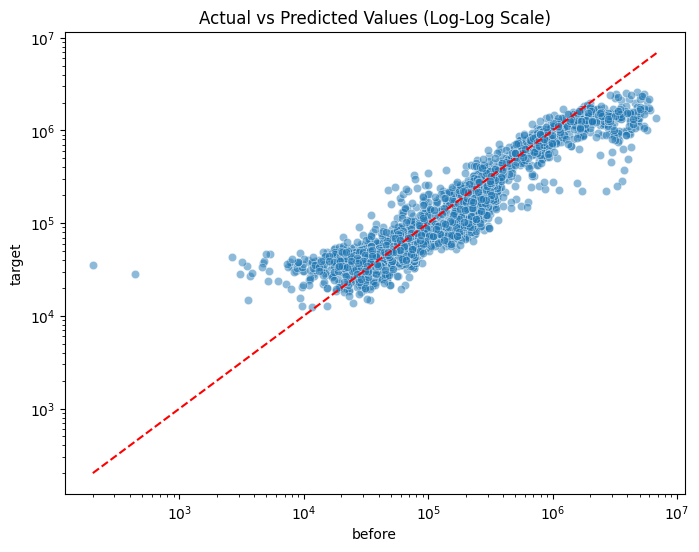

In [487]:

x=train_df["GHG_Direct_Emissions_12_in_metric_tons"]
y=train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
# 実測値と予測値を対数スケールでプロット
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('before')
plt.ylabel('target')
plt.title('Actual vs Predicted Values (Log-Log Scale)')
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')  # 45度線
plt.show()

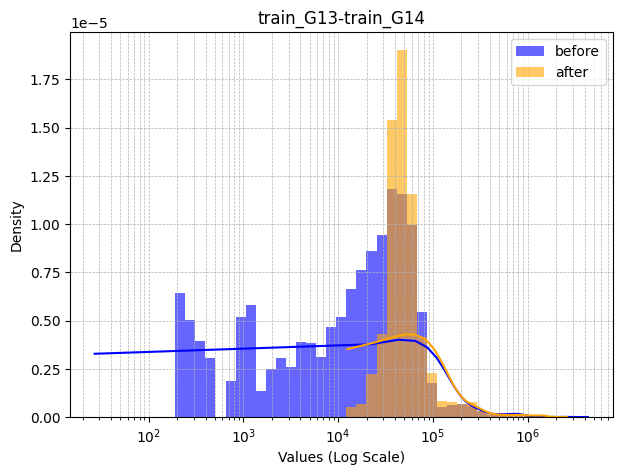

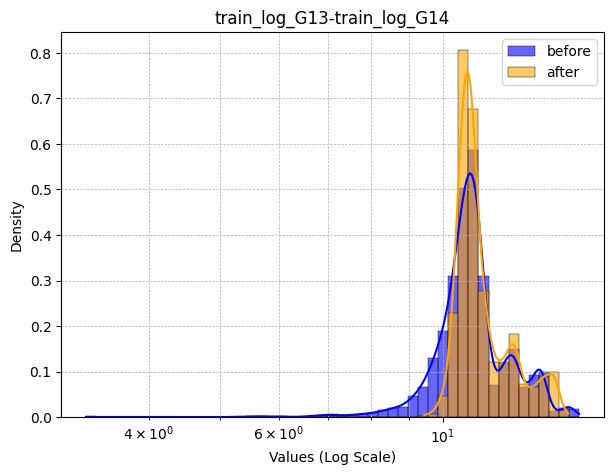

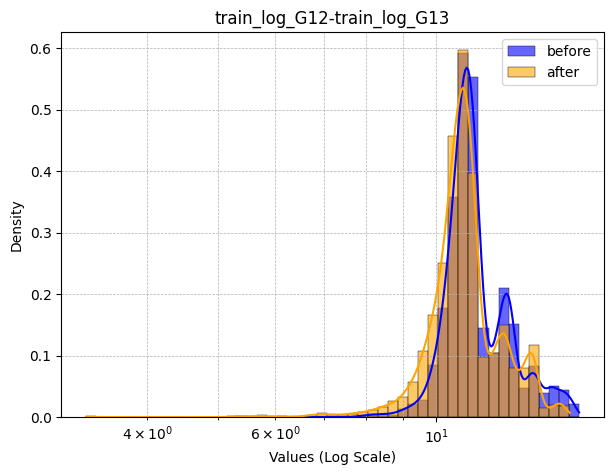

In [488]:

show_plot(train_df["GHG_Direct_Emissions_13_in_metric_tons"],
          train_df["GHG_Direct_Emissions_14_in_metric_tons.1"],
          "train_G13-train_G14")
show_plot(np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
          np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]),
          "train_log_G13-train_log_G14")
show_plot(np.log(train_df["GHG_Direct_Emissions_12_in_metric_tons"]),
          np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
          "train_log_G12-train_log_G13")


In [489]:
train_all_df = pd.concat([train_df, test_df], axis=0)
train_all_df["GHG_Direct_Emissions_14_in_metric_tons.1"][len(train_df):] = test_df["test_preds"]
print(train_all_df.columns)
train_all_df.drop('test_preds', axis=1, inplace=True)

test_df.rename(columns={'test_preds': 'oof_predictions'}, inplace=True)

Index(['TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
       'PrimaryNAICS', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing', 'oof_predictions',
       'GHG_Direct_Emissions_14_in_metric_tons.1', 'test_preds'],
      dtype='object')


In [490]:
train_all_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1
0,"23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"41,547","42,085"
1,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"59,347","58,732"
2,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"99,121","99,437"
3,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"51,450","51,725"
4,"30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"51,060","50,754"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"523,079","555,054"
2504,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"100,312","98,627"
2505,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"134,940","140,789"
2506,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"262,619","262,076"


In [491]:
diff = np.log1p(train_df['GHG_Direct_Emissions_14_in_metric_tons.1']) - np.log1p(train_df['oof_predictions'])

# 2. 条件を満たす行のマスクを作成
mask = diff > 1
# 3. 除外する行の数をカウント
exclude_num = mask.sum()
# 4. 条件を満たさない行だけを保持
train_df = train_df[~mask]
print(f"除外された行の数: {exclude_num}")

除外された行の数: 0


In [492]:
train_all_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1
0,"23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"41,547","42,085"
1,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"59,347","58,732"
2,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"99,121","99,437"
3,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"51,450","51,725"
4,"30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"51,060","50,754"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"523,079","555,054"
2504,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"100,312","98,627"
2505,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"134,940","140,789"
2506,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"262,619","262,076"


In [493]:
len(train_df), len(train_all_df), len(test_df)

(6045, 8553, 2508)

In [494]:
# 1. RMSLEの計算（ベクトル化）
# 'test_preds' と 'oof_predictions' を明示的に指定
diff = np.log1p(train_all_df['GHG_Direct_Emissions_14_in_metric_tons.1']) - np.log1p(train_all_df['oof_predictions'])
train_all_df['diff'] = diff
train_df = train_all_df[:len(train_df)]
test_df = train_all_df[-2508:]

In [495]:
train_all_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1,diff
0,"23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"41,547","42,085",0
1,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"59,347","58,732",-0
2,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"99,121","99,437",0
3,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"51,450","51,725",0
4,"30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"51,060","50,754",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"523,079","555,054",0
2504,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"100,312","98,627",-0
2505,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"134,940","140,789",0
2506,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"262,619","262,076",-0


In [496]:
train_all_df["oof_predictions"].fillna(train_all_df["GHG_Direct_Emissions_14_in_metric_tons.1"], inplace=True)
train_all_df["diff"].fillna(0, inplace=True)

In [497]:
train_all_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)
train_df_GHG14 = train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
train_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)

In [498]:
test_df["oof_predictions"] = test_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
test_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)

In [499]:
from itertools import combinations

def get_models_trained(train, test, target, num_folds, train_eval):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_eval_predictions = np.zeros(len(train_eval))

    # エラーの累計を保持する辞書
    sum_error = {}
    # 各組み合わせの選択回数を保持する辞書
    combination_count = {}

    # 個別モデルの名前リスト
    model_names = ["model1", "model2", "model3", "model4"]

    # 全ての組み合わせを生成（1, 2, 3, 4モデル）
    all_combinations = []
    for r in range(1, 5):
        all_combinations.extend(combinations(model_names, r))

    # 初期化
    for comb in all_combinations:
        sum_error[comb] = 0
        combination_count[comb] = 0

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"Starting Fold {fold + 1}")
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # モデルと損失の初期化
        model_dict = {}
        loss_dict = {}
        valid_pred_dict = {}

        # モデル1: XGBRegressor
        params1 = {
            "n_estimators": 626,
            "max_depth": 3,
            "random_state": 13,
            "min_child_weight": 0.001190123543553736,
            "learning_rate": 0.010519736270936835,
            "subsample": 0.7304788478701394,
            "colsample_bylevel": 0.604447278915981,
            "colsample_bytree": 0.7616852136157319,
            "reg_alpha": 0.115175569924065,
            "reg_lambda": 0.07155347824929895
        }
        model1 = XGBRegressor(**params1)

        # モデル2: CatBoostRegressor
        params                       = {'iterations': 254,
                                        'depth': 5,
                                        'learning_rate': 0.08377009991199288,
                                        'l2_leaf_reg': 1,
                                        'bagging_temperature': 0.7204457890870082,
                                        'min_data_in_leaf': 4,
                                        "random_state":13,
                                         "verbose":0}
        model2                       = CatBoostRegressor(**params)

        # モデル3: XGBRegressor
        params3 ={
            "n_estimators": 897,
            "max_depth": 4,
            "min_child_weight": 1.9636282677053687,
            "learning_rate": 0.006151391207761763,
            "subsample": 0.8251910979922186,
            "colsample_bylevel": 0.6454805596196158,
            "colsample_bytree": 0.598042694363472,
            "reg_alpha": 2.1719824223479005,
            "reg_lambda": 0.009192236594241635,
        }
        model3 = XGBRegressor(**params3)

        # モデル4: CatBoostRegressor
        params4 = {
            "iterations": 940,
            "depth": 3,
            "learning_rate": 0.019908189422344794,
            "l2_leaf_reg": 1,
            "bagging_temperature": 0.5063893392618839,
            "min_data_in_leaf": 1,
            'random_state': 42
        }
        model4 = CatBoostRegressor(**params4, verbose=0)

        # 各モデルの訓練と予測
        models = {
            "model1": model1,
            "model2": model2,
            "model3": model3,
            "model4": model4
        }

        for name, model in models.items():
            model.fit(X_train, y_train)
            preds = model.predict(X_valid)
            rmsle = np.sqrt(mean_squared_error(y_valid, preds))
            print(f"Fold {fold + 1} RMSLE for {name} = {rmsle}")
            loss_dict[name] = rmsle
            valid_pred_dict[name] = preds
            sum_error[(name,)] += rmsle

        # すべての2モデルおよび3モデルの組み合わせを評価
        for r in [2, 3]:
            for comb in combinations(model_names, r):
                # 平均予測
                preds_comb = np.mean([valid_pred_dict[model] for model in comb], axis=0)
                rmsle_comb = np.sqrt(mean_squared_error(y_valid, preds_comb))
                print(f"Fold {fold + 1} RMSLE for {comb} = {rmsle_comb}")
                loss_dict[comb] = rmsle_comb
                valid_pred_dict[comb] = preds_comb
                sum_error[comb] += rmsle_comb

        # 全モデルのアンサンブル
        preds_all = np.mean([valid_pred_dict[model] for model in model_names], axis=0)
        rmsle_all = np.sqrt(mean_squared_error(y_valid, preds_all))
        print(f"Fold {fold + 1} RMSLE for all models ensemble = {rmsle_all}")
        loss_dict[tuple(model_names)] = rmsle_all
        valid_pred_dict[tuple(model_names)] = preds_all
        sum_error[tuple(model_names)] += rmsle_all

        # 最適な組み合わせを選択
        best_combination = min(loss_dict, key=loss_dict.get)
        best_rmsle = loss_dict[best_combination]
        print(f"Fold {fold + 1} best combination: {best_combination} with RMSLE = {best_rmsle}")


        # OOF予測とテスト予測の更新
        if isinstance(best_combination, tuple):
            # 複数モデルのアンサンブル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = np.mean([models[model].predict(test) for model in best_combination], axis=0)
            train_eval_preds = np.mean([models[model].predict(train_eval) for model in best_combination], axis=0)
        else:
            # 単一モデル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = models[best_combination].predict(test)
            train_eval_preds = models[best_combination].predict(train_eval)

        # 各組み合わせの選択回数をインクリメント
        # combination_count[best_combination] += 1

        test_predictions += test_preds / kf.n_splits
        train_eval_predictions += train_eval_preds/ kf.n_splits

        # メモリの解放
        del X_train, X_valid, y_train, y_valid, model1, model2, model3, model4
        gc.collect()

        print('---------------\n')

    # 最終的なOOF RMSLEの計算
    final_RMSLE = np.sqrt(mean_squared_error(target, oof_predictions))
    print(f"OOF RMSLE = {final_RMSLE}")

    # テスト予測の逆変換
    final_test_predictions = test_predictions
    final_train_predictions = train_eval_predictions

    # 各組み合わせの累積エラーと選択回数を表示
    print("Sum of RMSLE for each combination:")
    for comb, error in sum_error.items():
        print(f"{comb}: {error}")

    # print("\nNumber of times each combination was selected:")
    # for comb, count in combination_count.items():
    #     print(f"{comb}: {count}")
    print()
    return oof_predictions, final_test_predictions, final_train_predictions

In [500]:
train_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,"23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"41,547",0
1,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"59,347",-0
2,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"99,121",0
3,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"51,450",0
4,"30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"51,060",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"542,859",0
6041,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"99,087",0
6042,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"135,588",0
6043,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"258,543",0


In [501]:
train = train_df.iloc[:, :-1].values
train_target = train_df.iloc[:, -1].values
train_all = train_all_df.iloc[:, :-1].values
train_all_target = train_all_df.iloc[:, -1].values
test = test_df.iloc[:, :-1].values

In [502]:
train_all_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,"23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"41,547",0
1,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"59,347",-0
2,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"99,121",0
3,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"51,450",0
4,"30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"51,060",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"523,079",0
2504,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"100,312",-0
2505,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"134,940",0
2506,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"262,619",-0


In [503]:
train_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,"23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"41,547",0
1,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"59,347",-0
2,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"99,121",0
3,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"51,450",0
4,"30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"51,060",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"542,859",0
6041,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"99,087",0
6042,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"135,588",0
6043,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"258,543",0


In [504]:
train_df_GHG14 = pd.Series(train_df_GHG14)

In [505]:
import time
epock = 10
for i in range(epock):
    st = time.time()
    train = train_df.iloc[:, :-1].values
    train_all = train_all_df.iloc[:, :-1].values
    train_all_target = train_all_df.iloc[:, -1].values
    oof_predictions,test_preds, train_preds  = get_models_trained(train_all, test, train_all_target, 30, train)
    train_all_df["oof_predictions"] = np.expm1(np.log1p(train_df["oof_predictions"])+train_preds)
    train_df["oof_predictions"] = np.expm1(np.log1p(train_df["oof_predictions"])+train_preds)
    test_df["oof_predictions"] = np.expm1(np.log1p(test_df["oof_predictions"])+test_preds)
    # train_all_df のインデックスをリセット
    train_all_df = train_all_df.reset_index(drop=True)

# train_df_GHG14 のインデックスをリセット
    train_df_GHG14 = train_df_GHG14.reset_index(drop=True)
    train_all_df['diff'] = np.log1p(train_df_GHG14) - np.log1p(train_all_df['oof_predictions'])
    train_all_df.fillna(0, inplace=True)
    train_df['diff'] = np.log1p(train_df_GHG14) - np.log1p(train_df['oof_predictions'])
    print(f"{i}番目の学習が終わりました。\n")
    print(f"推定時間は{int(((epock-1-i)*(time.time()-st))/60)}\n")

ストリーミング出力は最後の 5000 行に切り捨てられました。
Fold 18 RMSLE for ('model1', 'model2') = 0.007527552603546495
Fold 18 RMSLE for ('model1', 'model3') = 0.008147176486092313
Fold 18 RMSLE for ('model1', 'model4') = 0.007678039825515977
Fold 18 RMSLE for ('model2', 'model3') = 0.007743904055007763
Fold 18 RMSLE for ('model2', 'model4') = 0.0073041261062066765
Fold 18 RMSLE for ('model3', 'model4') = 0.007895584614697389
Fold 18 RMSLE for ('model1', 'model2', 'model3') = 0.007784894845785065
Fold 18 RMSLE for ('model1', 'model2', 'model4') = 0.0074879573264582866
Fold 18 RMSLE for ('model1', 'model3', 'model4') = 0.00788891701523189
Fold 18 RMSLE for ('model2', 'model3', 'model4') = 0.007622210202170212
Fold 18 RMSLE for all models ensemble = 0.007685923140444121
Fold 18 best combination: model2 with RMSLE = 0.007221802298878144
---------------

Starting Fold 19
Fold 19 RMSLE for model1 = 0.01191473539666094
Fold 19 RMSLE for model2 = 0.011496405638020296
Fold 19 RMSLE for model3 = 0.012063093108390282
Fo

In [506]:
train_all_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,"23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"42,054",0
1,0,0,221,"55,508","72,387","58,225","76,377",38,-81,0,0,0,0,0,0,14,1,"58,812",-0
2,0,0,4,0,0,0,0,39,-81,0,0,0,0,0,0,9,1,"99,096",0
3,0,0,21,"54,811","69,340","63,647","53,799",35,-119,0,0,0,0,0,0,15,1,"51,942",-0
4,"30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"50,908",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8548,0,0,240,"110,523","98,955","3,467,008","147,802",39,-76,0,0,0,0,0,0,1,1,0,0
8549,0,0,4,0,0,0,0,31,-102,0,0,0,0,0,0,9,1,0,0
8550,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,0,0
8551,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,0,0


In [507]:
train_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,"23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"42,054",0
1,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"58,812",-0
2,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"99,096",0
3,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"51,942",-0
4,"30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"50,908",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"562,304",NaN
6041,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"98,505",NaN
6042,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"137,926",NaN
6043,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"258,439",NaN


In [508]:
oof_predictions = pd.Series(oof_predictions, name='oof_predictions')


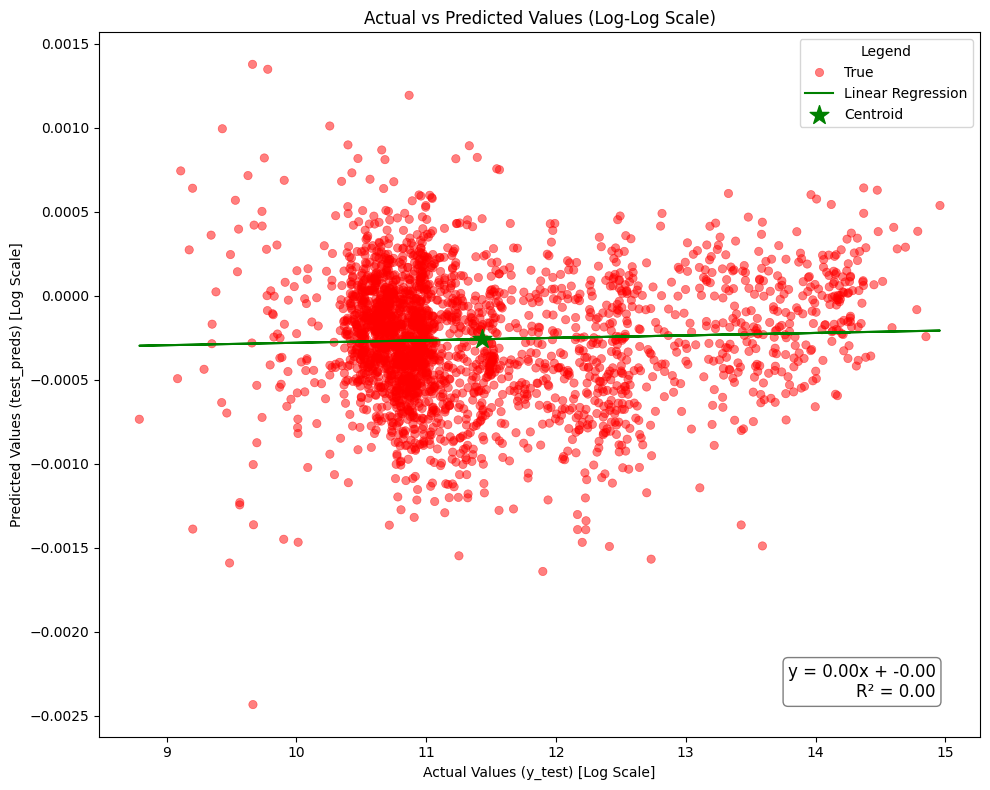

重心 (Centroid) の座標: (11.43, -0.00)


In [509]:
from scipy import stats
# 対数変換
log_target = np.log1p(test_df["oof_predictions"])
log_oof_predictions = test_preds

# 差の計算
diff = abs(log_target - log_oof_predictions)

# diffが0.7を超えるかどうかのマスク作成
diff_threshold = 0.7
mask = diff > diff_threshold

# プロットの作成
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x=log_target,
    y=log_oof_predictions,
    hue=mask,
    palette={False: 'blue', True: 'red'},
    alpha=0.5,
    edgecolor=None
)

plt.xlabel('Actual Values (y_test) [Log Scale]')
plt.ylabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')

# 線形回帰の計算
slope, intercept, r_value, p_value, std_err = stats.linregress(log_target, log_oof_predictions)
regression_line = slope * log_target + intercept

# 回帰線のプロット
plt.plot(log_target, regression_line, color='green', label='Linear Regression')

# 回帰式の作成
equation = f'y = {slope:.2f}x + {intercept:.2f}'
r_squared = r_value**2
equation_r2 = f'R² = {r_squared:.2f}'

# 回帰式をグラフ内の右下に表示
plt.text(
    0.95, 0.05,  # グラフ内の相対位置 (x, y) 0-1
    f'{equation}\n{equation_r2}',
    transform=plt.gca().transAxes,
    fontsize=12,
    horizontalalignment='right',
    verticalalignment='bottom',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

# 重心の計算
centroid_x = np.mean(log_target)
centroid_y = np.mean(log_oof_predictions)

# 重心をプロットに追加（plt.scatterを使用）
plt.scatter(
    centroid_x,
    centroid_y,
    color='green',
    marker='*',
    s=200,  # マーカーのサイズ
    label='Centroid'
)

# 凡例の設定
plt.legend(title='Legend')

# プロットの表示
plt.tight_layout()
plt.show()

# 重心の座標を表示
print(f"重心 (Centroid) の座標: ({centroid_x:.2f}, {centroid_y:.2f})")

In [510]:
train_df_GHG14

,GHG_Direct_Emissions_14_in_metric_tons.1
0,"42,085"
1,"58,732"
2,"99,437"
3,"51,725"
4,"50,754"
...,...
6040,NaN
6041,NaN
6042,NaN
6043,NaN


In [511]:
test_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,NaN,NaN,4,"88,951","65,803","28,993","32,965",38,-98,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"46,097",0
1,NaN,NaN,221,NaN,NaN,"311,926","268,668",32,-109,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"287,771",-0
2,"26,446","23,385",130,"84,908","6,213","34,733","39,045",41,-79,"3,800","-5,629","-3,061",0,-0,-0,8,0,"41,664",0
3,"43,906","42,958",82,"49,005",52,"14,262","20,205",45,-93,"5,174","1,402",-948,0,0,-0,8,0,"17,675",-0
4,"40,203","39,437",181,"84,960","15,351","40,007","63,935",33,-117,"-5,413",306,-766,-0,0,-0,8,0,"50,329",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"574,976",0
2504,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"97,869",-0
2505,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"143,550",0
2506,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"261,870",-0


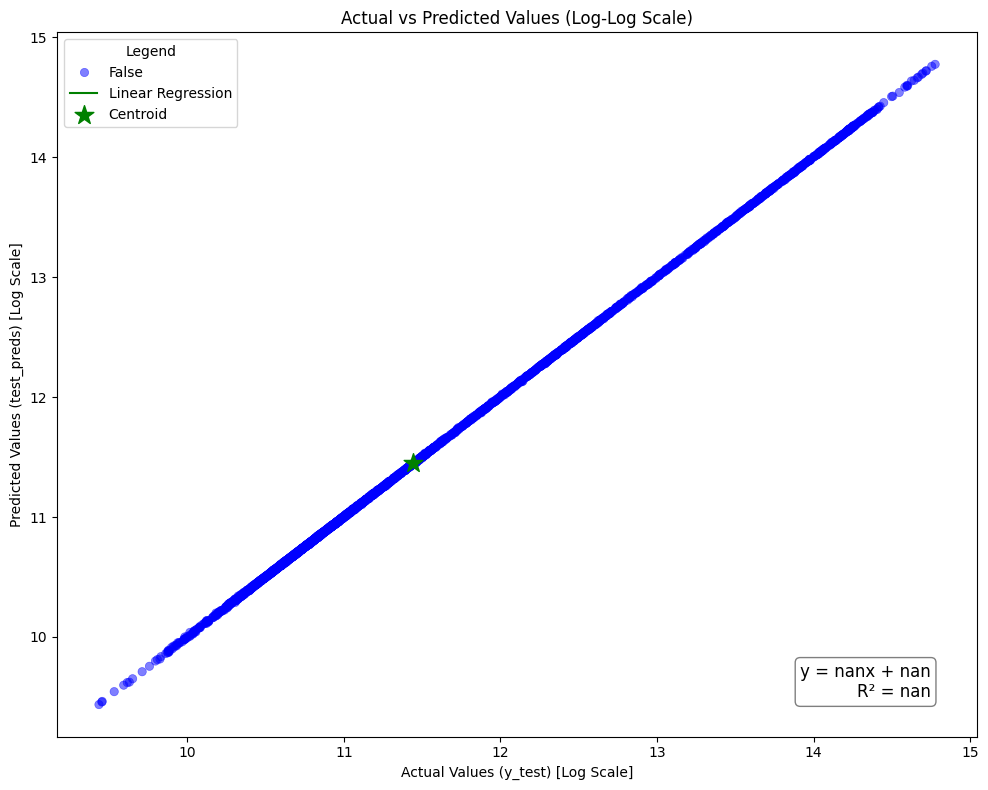

重心 (Centroid) の座標: (11.44, 11.45)


In [512]:

# 対数変換
log_target = np.log1p(train_df_GHG14)
log_oof_predictions = np.log1p(train_df["oof_predictions"])

# 差の計算
diff = abs(log_target - log_oof_predictions)

# diffが0.7を超えるかどうかのマスク作成
diff_threshold = 0.7
mask = diff > diff_threshold

# プロットの作成
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x=log_target,
    y=log_oof_predictions,
    hue=mask,
    palette={False: 'blue', True: 'red'},
    alpha=0.5,
    edgecolor=None
)

plt.xlabel('Actual Values (y_test) [Log Scale]')
plt.ylabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')

# 線形回帰の計算
slope, intercept, r_value, p_value, std_err = stats.linregress(log_target, log_oof_predictions)
regression_line = slope * log_target + intercept

# 回帰線のプロット
plt.plot(log_target, regression_line, color='green', label='Linear Regression')

# 回帰式の作成
equation = f'y = {slope:.2f}x + {intercept:.2f}'
r_squared = r_value**2
equation_r2 = f'R² = {r_squared:.2f}'

# 回帰式をグラフ内の右下に表示
plt.text(
    0.95, 0.05,  # グラフ内の相対位置 (x, y) 0-1
    f'{equation}\n{equation_r2}',
    transform=plt.gca().transAxes,
    fontsize=12,
    horizontalalignment='right',
    verticalalignment='bottom',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

# 重心の計算
centroid_x = np.mean(log_target)
centroid_y = np.mean(log_oof_predictions)

# 重心をプロットに追加（plt.scatterを使用）
plt.scatter(
    centroid_x,
    centroid_y,
    color='green',
    marker='*',
    s=200,  # マーカーのサイズ
    label='Centroid'
)

# 凡例の設定
plt.legend(title='Legend')

# プロットの表示
plt.tight_layout()
plt.show()

# 重心の座標を表示
print(f"重心 (Centroid) の座標: ({centroid_x:.2f}, {centroid_y:.2f})")

In [513]:
print(np.expm1(10.2))
print(np.log1p(26902.18607429754))
np.expm1(np.log1p(26902.18607429754)*100/102)

26902.18607429754
10.2


22025.465794806678

In [514]:
submit = pd.read_csv(path+'sample_submission.csv',  header = None)
submit

,0,1
0,4655,"249,574"
1,4656,"249,574"
2,4657,"249,574"
3,4658,"249,574"
4,4659,"249,574"
...,...,...
2503,7158,"249,574"
2504,7159,"249,574"
2505,7160,"249,574"
2506,7161,"249,574"


各ビンの y のジオメトリック平均: 185952.8162653598


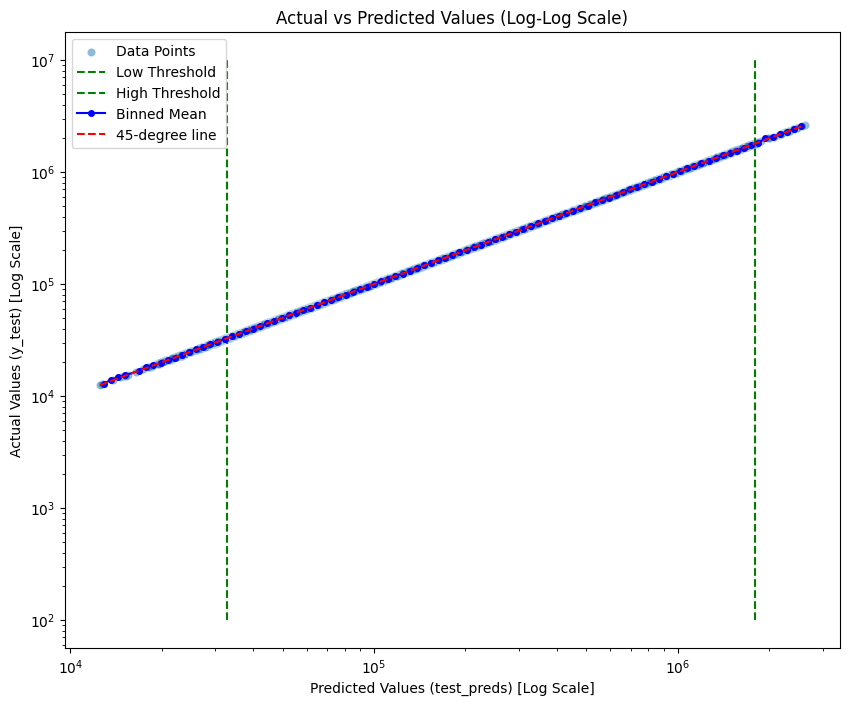

In [515]:

def calculate_binned_average(x, y, num_bins=50):
    """
    x を num_bins 個のビンに分け、それぞれのビン内の y の平均を計算します。

    Parameters:
    - x: 予測値の配列
    - y: 実測値の配列
    - num_bins: ビンの数

    Returns:
    - bins: ビンの境界
    - bin_centers: 各ビンの中心値
    - y_means: 各ビン内の y の平均値
    """
    # 対数スケールのビンを作成
    log_min = np.log10(x.min())
    log_max = np.log10(x.max())
    bins = np.logspace(log_min, log_max, num=num_bins)

    # ビンのインデックスを取得
    bin_indices = np.digitize(x, bins)

    # 各ビン内の y の平均を計算
    y_means = []
    bin_centers = []
    for i in range(1, len(bins)):
        mask = bin_indices == i
        if np.any(mask):
            y_mean = y[mask].mean()
            y_means.append(y_mean)
            bin_center = (bins[i-1] + bins[i]) / 2
            bin_centers.append(bin_center)

    return bins, np.array(bin_centers), np.array(y_means)


x = train_df_GHG14
y = train_df["oof_predictions"]
# ビンに分けて平均を計算
num_bins = 100
bins, bin_centers, y_means = calculate_binned_average(x, y, num_bins=num_bins)

# ジオメトリック平均の計算（ビンごとの y のジオメトリック平均）
geometric_mean_y_per_bin = np.exp(np.mean(np.log(y_means)))
print(f"各ビンの y のジオメトリック平均: {geometric_mean_y_per_bin}")

# プロットの作成
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x, y=y, alpha=0.5, label='Data Points')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Actual Values (y_test) [Log Scale]')
plt.xlabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')


# 基準点の垂直線のプロット
plt.plot([np.expm1(10.4), np.expm1(10.4)], [10**2, 10**7], 'g--', label='Low Threshold')
plt.plot([np.expm1(14.4), np.expm1(14.4)], [10**2, 10**7], 'g--', label='High Threshold')

# ビンごとの平均値の線を追加
plt.plot(bin_centers, y_means, color='b', linestyle='-', marker='o', markersize=4, label='Binned Mean')
# 45度線のプロット
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', label='45-degree line')

# 凡例の追加
plt.legend()

# プロットの表示
plt.show()

In [516]:
print(np.expm1(np.log1p(10)))

10.000000000000002


In [517]:
test_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,NaN,NaN,4,"88,951","65,803","28,993","32,965",38,-98,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"46,097",0
1,NaN,NaN,221,NaN,NaN,"311,926","268,668",32,-109,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"287,771",-0
2,"26,446","23,385",130,"84,908","6,213","34,733","39,045",41,-79,"3,800","-5,629","-3,061",0,-0,-0,8,0,"41,664",0
3,"43,906","42,958",82,"49,005",52,"14,262","20,205",45,-93,"5,174","1,402",-948,0,0,-0,8,0,"17,675",-0
4,"40,203","39,437",181,"84,960","15,351","40,007","63,935",33,-117,"-5,413",306,-766,-0,0,-0,8,0,"50,329",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"574,976",0
2504,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"97,869",-0
2505,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"143,550",0
2506,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"261,870",-0


In [518]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def after_act(preds):
    r = preds.copy()
    r_min = r.min()
    max_w = 10.4-np.log1p(r_min)
    for i in range(len(r)):
        if r[i] < np.expm1(10.4):
            # print(r[i]-np.expm1(np.log1p(r[i])-0.5*(10.4-np.log1p(r[i]))/max_w))
            r[i] = np.expm1(np.log1p(r[i])-0.5*(10.4-np.log1p(r[i]))/max_w)
    return r

after_test_preds = after_act(test_df["oof_predictions"])
after_train_preds = after_act(train_df["oof_predictions"])

各ビンの y のジオメトリック平均: nan


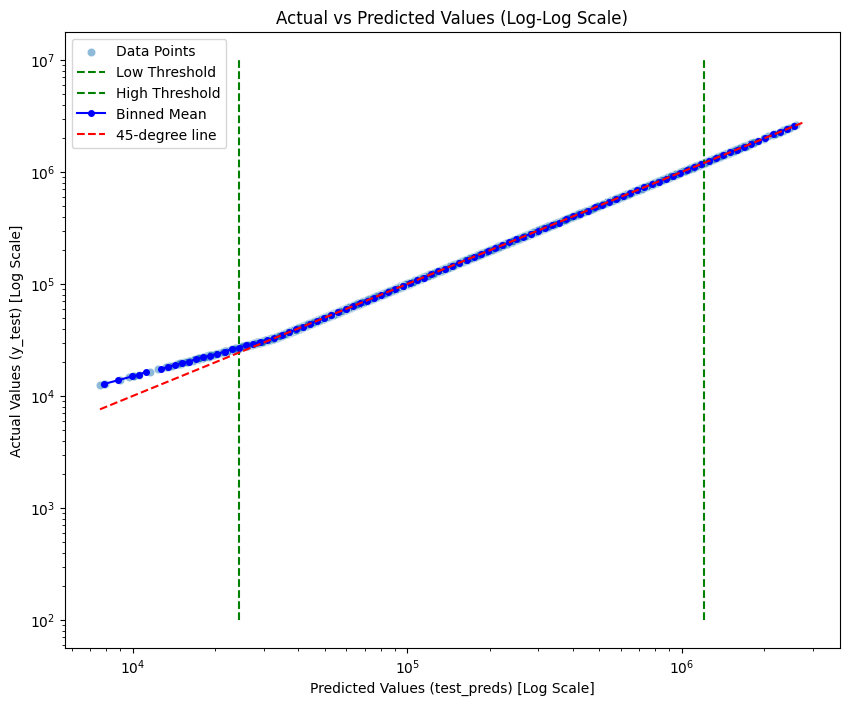

In [519]:
x = after_train_preds
y = train_df_GHG14

# ビンに分けて平均を計算
num_bins = 100
bins, bin_centers, y_means = calculate_binned_average(x, y, num_bins=num_bins)

# ジオメトリック平均の計算（ビンごとの y のジオメトリック平均）
geometric_mean_y_per_bin = np.exp(np.mean(np.log(y_means)))
print(f"各ビンの y のジオメトリック平均: {geometric_mean_y_per_bin}")

# プロットの作成
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x, y=y, alpha=0.5, label='Data Points')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Actual Values (y_test) [Log Scale]')
plt.xlabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')

# 45度線のプロット
# plt.plot([train_target.min(), train_target.max()], [train_target.min(), train_target.max()], 'r--', label='45-degree line')

# 基準点の垂直線のプロット
plt.plot([np.expm1(10.1), np.expm1(10.1)], [10**2, 10**7], 'g--', label='Low Threshold')
plt.plot([np.expm1(14.0), np.expm1(14.0)], [10**2, 10**7], 'g--', label='High Threshold')

# ビンごとの平均値の線を追加
plt.plot(bin_centers, y_means, color='b', linestyle='-', marker='o', markersize=4, label='Binned Mean')
# 45度線のプロット
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', label='45-degree line')

# 凡例の追加
plt.legend()

# プロットの表示
plt.show()

In [520]:
submit [ 1 ]  =  after_test_preds
submit.to_csv('SMBC_095.csv', index = False)
submit

,0,1
0,4655,"46,097"
1,4656,"287,771"
2,4657,"41,664"
3,4658,"14,578"
4,4659,"50,329"
...,...,...
2503,7158,"574,976"
2504,7159,"97,869"
2505,7160,"143,550"
2506,7161,"261,870"


In [521]:
submit

,0,1
0,4655,"46,097"
1,4656,"287,771"
2,4657,"41,664"
3,4658,"14,578"
4,4659,"50,329"
...,...,...
2503,7158,"574,976"
2504,7159,"97,869"
2505,7160,"143,550"
2506,7161,"261,870"


In [522]:
np.expm1(14)

1202603.2841647768

In [523]:
pd.set_option('display.float_format', '{:,.0f}'.format)
threshold_input = 14
threshold = np.expm1(threshold_input)/1.05  # ≈ 1.718

# フィルタリング条件を定義
condition = (submit.iloc[:, 1] > threshold) & (submit.iloc[:, 0] > 1)

# 条件に合致する行を抽出
filtered_submit = submit[condition]
filtered_submit

,0,1
43,4698,"1,264,492"
73,4728,"1,145,999"
110,4765,"1,408,698"
114,4769,"1,388,020"
148,4803,"1,742,764"
...,...,...
2417,7072,"1,278,458"
2423,7078,"1,207,340"
2466,7121,"1,772,265"
2490,7145,"1,445,204"


In [524]:

# # show_plot(np.exp(oof_predictions), np.exp(target))
# show_plot(oof_predictions, target, "oof_predictions, target")
# show_plot(np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]), np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]),
#           "train_df[GHG_Direct_Emissions_13_in_metric_tons], np.log(train_df[GHG_Direct_Emissions_14_in_metric_tons.1])")
# show_plot(np.log(test_df["GHG_Direct_Emissions_13_in_metric_tons"]), np.log(after_test_preds),
#           "test_df[GHG_Direct_Emissions_13_in_metric_tons], test_preds")
# show_plot(np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]), np.log(after_test_preds),
#           "train_df[GHG_Direct_Emissions_14_in_metric_tons], test_preds")
# show_plot(train_df.iloc[:, -1], after_train_preds, "train_df.iloc[:, -1], train_preds")

In [525]:
# show_plot(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"], test_preds, "test_df[GHG_Direct_Emissions_13_in_metric_tons], test_preds")

In [526]:
import time
print(time.ctime())

Mon Dec  2 15:12:38 2024


In [527]:
train_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,"23,410","31,810",118,"64,817","36,589","37,908","45,598",40,-88,"-4,922","-3,235","8,399",-0,-0,0,8,0,"42,054",0
1,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"58,812",-0
2,NaN,NaN,4,NaN,NaN,NaN,NaN,39,-81,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"99,096",0
3,NaN,NaN,21,"54,811","69,340","63,647","53,799",35,-119,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"51,942",-0
4,"30,841","25,154",21,"81,812","53,824","77,391","17,663",42,-82,"-1,216","2,503","-5,687",-0,0,-0,15,0,"50,908",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"562,304",NaN
6041,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"98,505",NaN
6042,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"137,926",NaN
6043,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"258,439",NaN


In [ ]:
train_df
